### Выпускной проект.

#### Описание проекта. Промышленность
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил  уменьшить 
потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.
Задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для
имитации технологического процесса.

#### Описание процесса обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

#### Описание данных
        Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
    steel.data_arc — данные об электродах;
    steel.data_bulk — данные об объёме сыпучих материалов;
    steel.data_bulk_time — данные о времени подачи сыпучих материалов;
    steel.data_gas — данные о продувке сплава газом;
    steel.data_temp — данные об измерениях температуры;
    steel.data_wire — данные об объёме проволочных материалов;
    steel.data_wire_time — данные о времени подачи проволочных материалов.
    
    Таблица steel.data_arc
    key — номер партии;
    BeginHeat — время начала нагрева;
    EndHeat — время окончания нагрева;
    ActivePower — значение активной мощности;
    ReactivePower — значение реактивной мощности.

    Таблица steel.data_bulk
    key — номер партии;
    Bulk1 … Bulk15 — объём подаваемого материала.
    Таблица steel.data_bulk_time
    key — номер партии;
    Bulk1 … Bulk15 — время подачи материала.
    Таблица steel.data_gas
    key — номер партии;
    gas — объём подаваемого газа.

    Таблица steel.data_temp
    key — номер партии;
    MesaureTime — время замера;
    Temperature — значение температуры.
    Таблица steel.data_wire
    key — номер партии;
    Wire1 … Wire15 — объём подаваемых проволочных материалов.

    Таблица steel.data_wire_time
    Key — номер партии;
    Wire1 … Wire15 — время подачи проволочных материалов.
    
   Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

Загрузим и установим необходимые инстроменты.

In [1]:
#!pip install phik
#!pip install shap

In [2]:
#!pip install hyperopt

In [3]:
# Пропишем импорты

import time
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import math
import random

from sqlalchemy import create_engine

import phik
from phik.report import plot_correlation_matrix
from phik import report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler

import catboost

from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
import shap
from tensorflow import keras
from keras.layers import Dropout
from tensorflow.keras import callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_diabetes
import tensorflow as tf


In [5]:
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, anneal, STATUS_OK

In [6]:
import seaborn as sns

In [7]:
from lightgbm import LGBMRegressor

Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.


Установим размер для графиков.

In [8]:
plt.rcParams["figure.figsize"] = (10,10)

In [9]:
# Пропишем функицию

def df_info(df, name):
    
    '''Подробная информация о конкретном DF'''
    
    df.name = name
    
    print(f'Информация о {df.name} (кол-во столбцов {df.shape[1]}, кол-во строк {df.shape[0]})')
    print()
    
    display(df.head(10), df.info(memory_usage = True), df.describe(), df.isna().sum())

def data_spread(df, column_list):
    
    '''Разброс данных. Отображение диаграммы размаха и гистограммы. Входные данные list колонок и df'''
    
    for column in column_list:
        df.boxplot(column=column)
        plt.title(f'Диаграмма размаха на столбце {column}')
        plt.show()
        df[column].plot(kind='hist', bins=100, grid=True)
        plt.title(f'Гистограмма на столбце {column}')
        plt.xlabel(column)
        plt.ylabel('Кол-во наблюдений')
        plt.show()
        print('--------------------------------------------')
        

In [10]:
RANDOM_STATE = 20223

##### Подквючимся к базе данных и загрузим раблицы.

In [11]:

db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}


In [12]:
# Создадим строку для соединения

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [13]:
# Создадим соединение
engine = create_engine(connection_string)

In [14]:
# Для начала исследуем все таблицы
data_arc = '''

SELECT *
FROM steel.data_arc

'''


data_bulk = '''

SELECT *
FROM steel.data_bulk

'''
data_bulk_time = '''

SELECT *
FROM steel.data_bulk_time

'''

data_gas = '''

SELECT *
FROM steel.data_gas

'''

data_temp = '''

SELECT *
FROM steel.data_temp

'''

data_wire = '''

SELECT *
FROM steel.data_wire

'''

data_wire_time = '''

SELECT *
FROM steel.data_wire_time

'''

In [15]:
# Выгрузим таблицу collisions в DF
data_arc = pd.read_sql_query(data_arc, con = engine)
data_bulk = pd.read_sql_query(data_bulk, con = engine)
data_bulk_time = pd.read_sql_query(data_bulk_time, con = engine)
data_gas = pd.read_sql_query(data_gas, con = engine)
data_temp = pd.read_sql_query(data_temp, con = engine)
data_wire = pd.read_sql_query(data_wire, con = engine)
data_wire_time = pd.read_sql_query(data_wire_time, con = engine)

##### Проведем анализ таблицы   data_arc.  
    key — номер партии;
    BeginHeat — время начала нагрева;
    EndHeat — время окончания нагрева;
    ActivePower — значение активной мощности;
    ReactivePower — значение реактивной мощности.

In [16]:
df_info(data_arc, 'data_arc')

Информация о data_arc (кол-во столбцов 5, кол-во строк 14876)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


key BeginHeat   EndHeat  ActivePower  ReactivePower
0    1  11:02:14  11:06:02     0.976059       0.687084
1    1  11:07:28  11:10:33     0.805607       0.520285
2    1  11:11:44  11:14:36     0.744363       0.498805
3    1  11:18:14  11:24:19     1.659363       1.062669
4    1  11:26:09  11:28:37     0.692755       0.414397
5    2  11:34:14  11:36:31     0.438063       0.283043
6    2  11:38:50  11:44:28     1.296415       0.892914
7    2  11:46:19  11:48:25     0.490377       0.305281
8    2  11:49:48  11:53:18     0.827743       0.516874
9    3  12:06:54  12:11:34     1.062053       0.671494

None

key   ActivePower  ReactivePower
count  14876.000000  14876.000000   14876.000000
mean    1615.220422      0.670441       0.452592
std      934.571502      0.408159       5.878702
min        1.000000      0.030002    -715.504924
25%      806.000000      0.395297       0.290991
50%     1617.000000      0.555517       0.415962
75%     2429.000000      0.857034       0.637371
max     3241.000000      3.731596       2.676388

key              0
BeginHeat        0
EndHeat          0
ActivePower      0
ReactivePower    0
dtype: int64

In [17]:
data_arc.head()

key BeginHeat   EndHeat  ActivePower  ReactivePower
0    1  11:02:14  11:06:02     0.976059       0.687084
1    1  11:07:28  11:10:33     0.805607       0.520285
2    1  11:11:44  11:14:36     0.744363       0.498805
3    1  11:18:14  11:24:19     1.659363       1.062669
4    1  11:26:09  11:28:37     0.692755       0.414397

Создадим столбец с колличеством секунд работы электродов. 

In [18]:
data_arc['second'] = ((pd.to_datetime(data_arc['EndHeat'], format='%H:%M:%S')) -\
                      (pd.to_datetime(data_arc['BeginHeat'], format='%H:%M:%S'))).dt.total_seconds()#.astype('Int64')

Создадим таблицу с количеством часов и секунд затраченных на обработку каждой партии.

In [19]:
data_arc.groupby('key')['EndHeat'].last()

key
1       11:28:37
2       11:53:18
3       12:32:19
4       12:57:50
5       13:33:55
          ...   
3237    23:03:48
3238    23:41:28
3239    02:15:43
3240    03:34:08
3241    04:36:08
Name: EndHeat, Length: 3214, dtype: object

In [20]:
data_second = data_arc.groupby('key')['BeginHeat'].first().to_frame().join(data_arc.groupby('key')['EndHeat'].last().to_frame())

In [21]:
data_second['tot_second'] = ((pd.to_datetime(data_second['EndHeat'], format='%H:%M:%S')) -\
                      (pd.to_datetime(data_second['BeginHeat'], format='%H:%M:%S'))).dt.total_seconds()#.astype('Int64')
data_second.loc[data_second['tot_second'] < 0, 'tot_second']= 86400 + data_second['tot_second']
data_second = data_second.drop(['BeginHeat','EndHeat'], axis =1)

In [22]:
data_second['haur'] = data_second['tot_second']/3600


In [23]:
data_second['haur'] = data_second['haur'].round(2)

Посмотрим на первые 5 строк таблицы. 

In [24]:
data_second.head()

tot_second  haur
key                  
1        1583.0  0.44
2        1144.0  0.32
3        1525.0  0.42
4        1093.0  0.30
5        1362.0  0.38

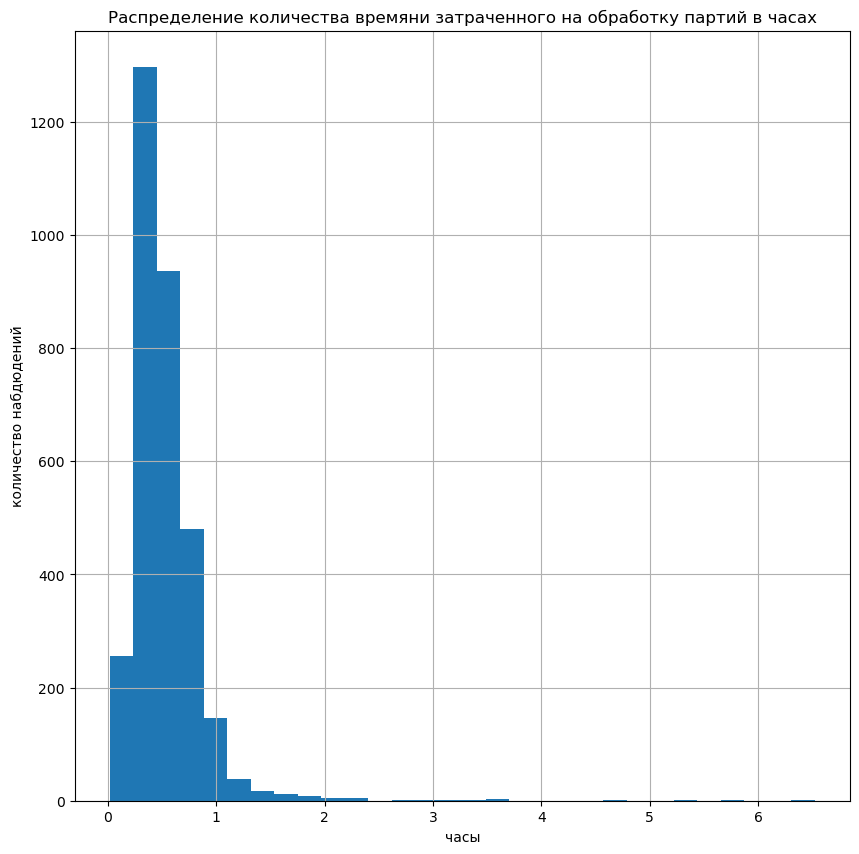

In [25]:
data_second['haur'].hist(bins = 30)
plt.title('Распределение количества времяни затраченного на обработку партий в часах')
plt.ylabel('количество набдюдений')
plt.xlabel('часы')
plt.show()

Некоторые партии обрабатывались более пяти часов.

In [26]:
data_second[data_second['haur']>3]

tot_second  haur
key                   
44       10910.0  3.03
46       12146.0  3.37
638      13194.0  3.66
641      17134.0  4.76
801      12714.0  3.53
1513     11233.0  3.12
1689     23485.0  6.52
1880     11776.0  3.27
1881     12656.0  3.52
1958     19108.0  5.31
2108     20982.0  5.83

In [27]:
data_arc[data_arc['key']==2108]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second
9735  2108  14:05:57  14:08:12     0.442274       0.327734   135.0
9736  2108  14:32:08  14:33:35     0.334060       0.273037    87.0
9737  2108  14:38:21  14:39:16     0.242396       0.171868    55.0
9738  2108  14:40:29  14:41:29     0.252583       0.191510    60.0
9739  2108  14:44:10  14:46:08     0.487753       0.375812   118.0
9740  2108  14:47:56  14:50:51     0.762996       0.580148   175.0
9741  2108  17:04:16  17:07:58     0.748764       0.573281   222.0
9742  2108  17:10:03  17:13:03     0.705522       0.696271   180.0
9743  2108  17:14:20  17:22:24     1.914019       1.932725   484.0
9744  2108  17:23:04  17:27:05     0.854662       1.031376   241.0
9745  2108  18:32:31  18:36:32     1.023661       0.886447   241.0
9746  2108  18:39:40  18:41:05     0.355419       0.322583    85.0
9747  2108  18:43:30  18:50:35     1.491414       1.967679   425.0
9748  2108  18:54:16  18:54:50     0.132325       0.121500    34.0
9749  2108  19:44:35  19:46:11     0.301984       0.270264    96.0
9750  2108  19:53:58  19:55:39     0.377109       0.350585   101.0

Удалять партиии с долговременной обработкой пока не будем.

In [28]:
len(data_arc['key'].unique())

3214

In [29]:
data_arc.isna().sum()

key              0
BeginHeat        0
EndHeat          0
ActivePower      0
ReactivePower    0
second           0
dtype: int64

Посмотрим на анамальные значения, есть ли строки с отрицательным количестовом секунд
работы электродов.

In [30]:
data_arc[data_arc['second']<=0]

key BeginHeat   EndHeat  ActivePower  ReactivePower   second
580     126  23:59:35  00:01:55     0.527388       0.405463 -86260.0
1170    257  23:58:57  00:00:07     0.268811       0.175647 -86330.0
1280    280  23:56:57  00:01:43     1.197192       0.728587 -86114.0
1953    421  23:58:33  00:01:57     0.774585       0.583186 -86196.0
2952    642  23:52:55  00:03:13     2.415316       1.946081 -85782.0
3438    745  23:58:27  00:00:14     0.403792       0.281718 -86293.0
4250    913  23:58:22  00:01:34     0.787956       0.537366 -86208.0
4752   1026  23:59:04  00:07:07     1.680239       1.400063 -85917.0
5400   1175  23:59:25  00:05:07     1.325558       0.893414 -86058.0
6456   1404  23:56:33  00:01:05     1.217748       0.833978 -86128.0
6840   1486  23:56:24  00:01:21     1.135938       0.713006 -86103.0
6986   1515  23:58:56  00:02:11     0.756416       0.500854 -86205.0
7233   1572  23:57:55  00:00:13     0.476221       0.363946 -86262.0
7864   1702  23:58:32  00:00:14     0.430305       0.310953 -86298.0
9513   2063  23:58:36  00:00:41     0.566324       0.379927 -86275.0
9911   2147  23:56:54  00:02:00     1.359492       0.975441 -86094.0
10199  2211  23:58:35  00:02:11     0.853027       0.704497 -86184.0
11328  2468  23:58:41  00:01:14     0.532269       0.404410 -86247.0
12136  2638  23:58:18  00:00:51     0.534497       0.429733 -86247.0
12545  2725  23:58:08  00:03:15     1.215787       0.895574 -86093.0
12750  2769  23:59:08  00:02:10     0.696097       0.427802 -86218.0
12867  2798  23:57:30  00:00:32     0.724873       0.450309 -86218.0

Отрецательное время есть так как, печь работает круглосуточно, алгоритм посчитал верно.
Чтобы коректировать сторчки с отрецательным времянем поступим просто - возьмем строчку с 
отрецательным времянем и просто прибавим к нему количество секунд в сутках, таким 
образом у нас будет точное количество секунд работы электродов не смотря на то, что они
были включены до 00:00:00  а выключены после двенидцати ночи т.е во времянном промежутке
следующих суток.

In [31]:
data_arc.loc[data_arc['second']<=0, 'second']= 3600*24 + data_arc['second']

Проанализируем столбцы с затраченной мощьностью электродов.

Столбец ActivePower — значение активной мощности.

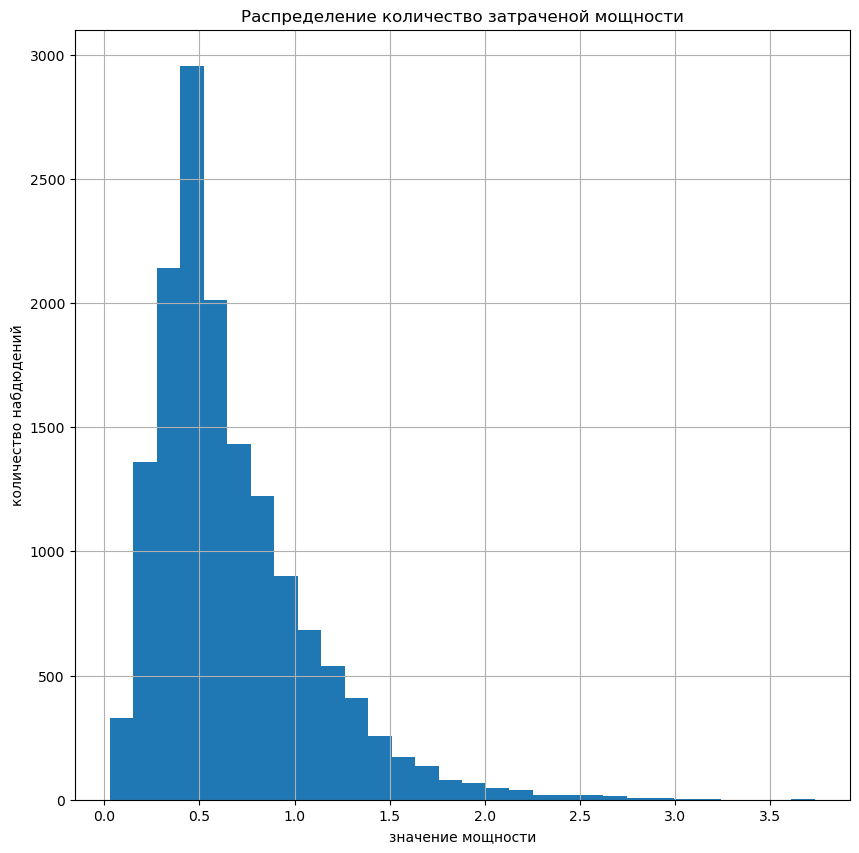

In [32]:
data_arc['ActivePower'].hist(bins=30)
plt.title('Распределение количество затраченой мощности')
plt.ylabel('количество набдюдений')
plt.xlabel('значение мощности')
plt.show()

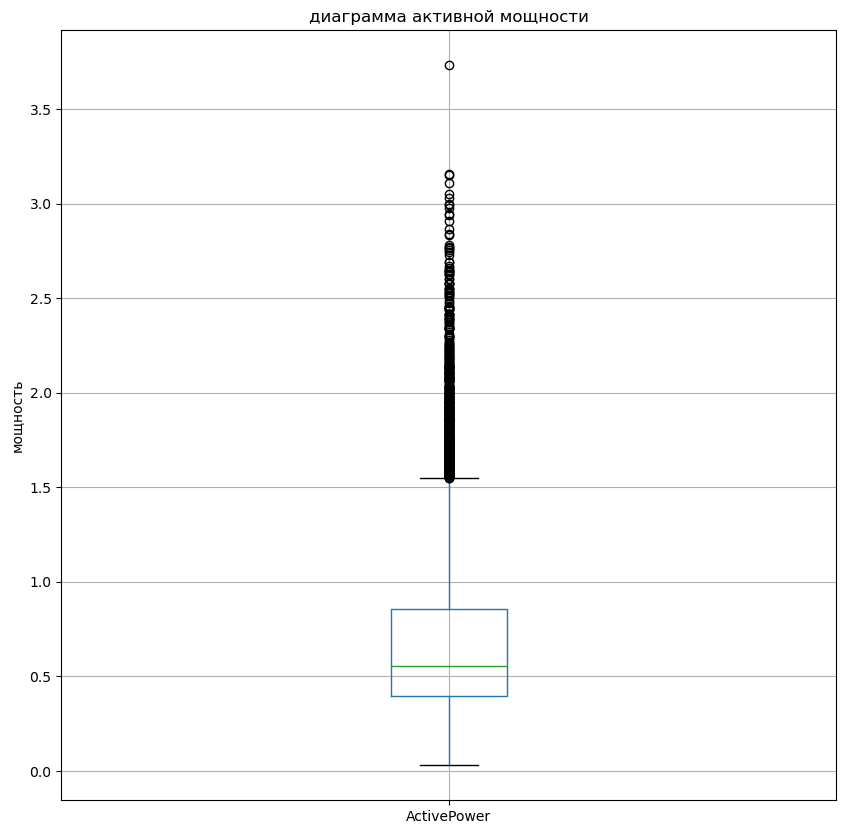

In [33]:
data_arc.boxplot(column='ActivePower')
plt.title('диаграмма активной мощности')
plt.ylabel('мощность')
plt.show()

Посмотрим наданные о партиях споказателем активной мощности выше 3.

In [34]:
data_arc[data_arc['ActivePower']>3]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second
7799   1689  18:49:03  19:04:10     3.731596       2.676388   907.0
9227   2001  20:19:15  20:31:16     3.156276       2.504206   721.0
9871   2139  17:01:13  17:12:06     3.107820       1.946782   653.0
12425  2701  06:11:16  06:25:02     3.150762       2.397032   826.0
13277  2890  06:19:59  06:30:28     3.029744       1.946579   629.0
14200  3086  03:41:09  03:53:10     3.052813       2.216230   721.0

In [35]:
data_arc[data_arc['key']==1689]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second
7793  1689  15:25:34  15:27:11     0.337803       0.242150    97.0
7794  1689  15:30:19  15:35:41     1.230050       0.809881   322.0
7795  1689  15:39:06  15:43:49     1.211215       0.852895   283.0
7796  1689  15:51:04  15:54:19     0.857824       0.559878   195.0
7797  1689  15:59:13  16:01:30     0.605553       0.394115   137.0
7798  1689  18:41:20  18:46:25     1.174942       0.997666   305.0
7799  1689  18:49:03  19:04:10     3.731596       2.676388   907.0
7800  1689  19:57:33  20:08:31     2.864100       2.150657   658.0
7801  1689  20:09:54  20:20:02     2.643099       1.823933   608.0
7802  1689  21:23:27  21:25:32     0.519904       0.397048   125.0
7803  1689  21:26:34  21:27:47     0.294199       0.224430    73.0
7804  1689  21:29:27  21:32:44     0.837295       0.570071   197.0
7805  1689  21:37:37  21:38:44     0.274812       0.204592    67.0
7806  1689  21:48:42  21:50:30     0.459718       0.347997   108.0
7807  1689  21:55:12  21:56:59     0.454386       0.336290   107.0

In [36]:
data_arc[data_arc['key']==2701]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second
12424  2701  06:07:33  06:10:09     0.502294       0.372267   156.0
12425  2701  06:11:16  06:25:02     3.150762       2.397032   826.0
12426  2701  06:32:41  06:37:11     1.047496       0.755871   270.0
12427  2701  06:38:12  06:39:24     0.281175       0.199856    72.0

In [37]:
data_arc[data_arc['key']==3086]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second
14199  3086  03:35:58  03:37:59     0.423518       0.320388   121.0
14200  3086  03:41:09  03:53:10     3.052813       2.216230   721.0
14201  3086  03:57:38  04:00:40     0.827833       0.557215   182.0
14202  3086  04:01:43  04:05:16     0.972601       0.642887   213.0
14203  3086  04:08:13  04:11:24     0.878697       0.578185   191.0
14204  3086  04:13:07  04:14:51     0.484126       0.311869   104.0

Удалять  партию 1689 не будем. 

Посмотрим на данные партий где мощность ниже 0,05. 

In [38]:
data_arc[data_arc['ActivePower']<0.05]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second
676     146  19:18:55  19:19:07     0.035400       0.023228    12.0
2420    521  17:42:57  17:43:11     0.030563       0.021154    14.0
3199    692  23:37:14  23:37:28     0.047056       0.028718    14.0
4064    873  18:34:19  18:34:30     0.040905       0.023569    11.0
4616    996  22:06:27  22:09:03     0.035165       0.026222   156.0
4634   1000  01:17:44  01:17:57     0.038186       0.022983    13.0
4915   1060  04:31:57  04:32:08     0.031630       0.022485    11.0
5321   1154  08:35:37  08:35:48     0.030190       0.026755    11.0
5597   1216  08:22:19  08:22:30     0.030188       0.020806    11.0
6581   1432  21:13:19  21:13:34     0.034053       0.025329    15.0
6591   1433  22:25:11  22:25:22     0.043912       0.028447    11.0
7372   1601  21:45:53  21:46:04     0.030002       0.026542    11.0
8705   1892  18:51:37  18:51:50     0.038364       0.026079    13.0
8987   1949  12:02:19  12:02:33     0.040689       0.034656    14.0
9163   1987  06:40:25  06:40:36     0.045408       0.033172    11.0
9891   2142  20:26:02  20:26:16     0.036282       0.048501    14.0
10593  2303  03:59:48  04:00:04     0.040091       0.027138    16.0
11802  2567  16:00:04  16:00:15     0.035852       0.035957    11.0
11803  2567  16:05:36  16:05:53     0.049223       0.042240    17.0
12361  2686  16:37:53  16:38:08     0.046895       0.028834    15.0

In [39]:
data_arc[data_arc['key']==1601]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second
7370  1601  21:26:15  21:27:29     0.250823       0.186430    74.0
7371  1601  21:31:16  21:32:44     0.307511       0.231464    88.0
7372  1601  21:45:53  21:46:04     0.030002       0.026542    11.0

In [40]:
data_arc[data_arc['key']==1433]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second
6587  1433  21:42:50  21:44:29     0.327745       0.239955    99.0
6588  1433  21:51:56  21:58:01     1.430620       1.143804   365.0
6589  1433  22:10:48  22:13:51     0.791592       0.536124   183.0
6590  1433  22:19:44  22:21:14     0.396886       0.294324    90.0
6591  1433  22:25:11  22:25:22     0.043912       0.028447    11.0

In [41]:
data_arc[data_arc['key']==146]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second
675  146  19:14:36  19:16:56     0.458781       0.301910   140.0
676  146  19:18:55  19:19:07     0.035400       0.023228    12.0
677  146  19:20:14  19:28:44     1.848239       1.322431   510.0
678  146  19:39:10  19:43:29     0.999431       0.660729   259.0
679  146  19:52:27  19:55:39     0.735356       0.491051   192.0
680  146  20:01:19  20:02:47     0.329319       0.225175    88.0

Ничего не удаляем.

Для более объективного анализа расчитаем сколько моности тратят электроды за одну минуту,
таким образом можно будет вычислить анамальные значения в таблице. На самом деле под понятием
мощьность я имею ввиду колличество работы, так уж полочилось, что принято работу измерять
мощностью.

In [42]:
data_arc['minut_power_active'] = (data_arc['ActivePower']/data_arc['second'])*60

In [43]:
data_arc['minut_power_reactive'] = (data_arc['ReactivePower']/data_arc['second'])*60

Посмотрим на распределение количества мощьности за одну минуту.

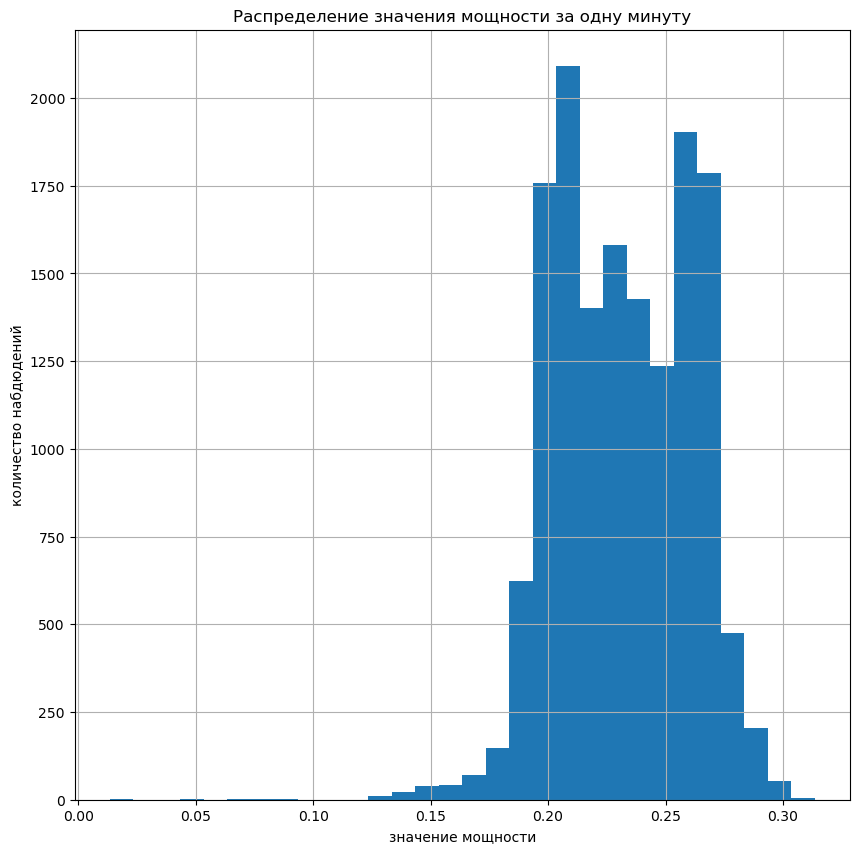

In [44]:
data_arc['minut_power_active'].hist(bins=30)
plt.title('Распределение значения мощности за одну минуту')
plt.ylabel('количество набдюдений')
plt.xlabel('значение мощности')
plt.show()

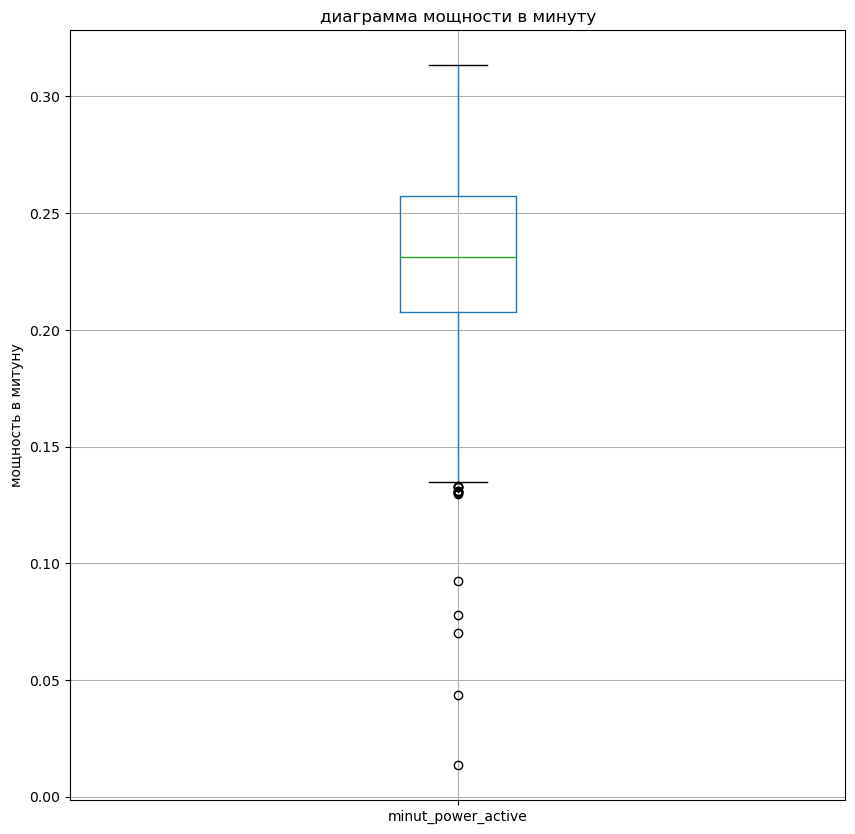

In [45]:
data_arc.boxplot(column='minut_power_active')
plt.title('диаграмма мощности в минуту')
plt.ylabel('мощность в митуну')
plt.show()

In [46]:
data_arc[data_arc['minut_power_active']<0.14]#['key']

key BeginHeat   EndHeat  ActivePower  ReactivePower  second  \
2420    521  17:42:57  17:43:11     0.030563       0.021154    14.0   
2451    528  21:36:34  21:42:12     0.246265       0.167929   338.0   
2544    552  21:25:35  21:32:58     0.978527       2.100782   443.0   
4353    935  00:28:16  00:31:24     0.410306       0.349664   188.0   
4354    935  00:34:46  00:38:59     0.546657       0.446735   253.0   
4355    935  00:47:14  00:51:02     0.495849       0.393928   228.0   
4356    935  00:54:58  00:57:01     0.276379       0.218080   123.0   
4616    996  22:06:27  22:09:03     0.035165       0.026222   156.0   
4665   1007  08:12:59  08:16:56     0.552626       0.522666   237.0   
4671   1009  09:33:15  09:36:18     0.213525       0.162815   183.0   
6193   1349  02:34:21  02:36:02     0.155590       0.131753   101.0   
6581   1432  21:13:19  21:13:34     0.034053       0.025329    15.0   
6991   1516  23:50:17  23:52:24     0.292789       0.281405   127.0   
7915   1714  08:18:02  08:21:44     0.501251       0.471765   222.0   
7936   1719  12:07:57  12:10:18     0.321381       0.283998   141.0   
7938   1720  12:44:34  12:49:39     0.673718       0.654839   305.0   
8582   1869  17:47:22  17:52:44     0.736119       0.690779   322.0   
8598   1872  20:39:30  20:45:21     0.763824       0.746414   351.0   
8602   1873  21:38:49  21:46:05     0.968497       0.874320   436.0   
8752   1903  05:00:16  05:01:56     0.129953       0.103430   100.0   
9897   2144  21:04:14  21:07:33     0.440487       0.424576   199.0   
11411  2488  19:52:58  19:54:27     0.205652       0.414734    89.0   
12626  2743  23:20:55  23:23:02     0.288679       0.583113   127.0   
12795  2780  08:32:33  08:33:43     0.161708       0.246912    70.0   
12797  2780  08:40:03  08:43:07     0.398844       0.780873   184.0   
12798  2780  08:44:57  08:48:26     0.472234       1.031123   209.0   

       minut_power_active  minut_power_reactive  
2420             0.130984              0.090661  
2451             0.043716              0.029810  
2544             0.132532              0.284530  
4353             0.130949              0.111595  
4354             0.129642              0.105945  
4355             0.130487              0.103665  
4356             0.134819              0.106381  
4616             0.013525              0.010085  
4665             0.139905              0.132320  
4671             0.070008              0.053382  
6193             0.092429              0.078269  
6581             0.136211              0.101317  
6991             0.138326              0.132947  
7915             0.135473              0.127504  
7936             0.136758              0.120850  
7938             0.132535              0.128821  
8582             0.137165              0.128717  
8598             0.130568              0.127592  
8602             0.133279              0.120319  
8752             0.077972              0.062058  
9897             0.132810              0.128013  
11411            0.138642              0.279596  
12626            0.136384              0.275486  
12795            0.138607              0.211639  
12797            0.130058              0.254632  
12798            0.135569              0.296016

In [47]:
list_part = list(data_arc[data_arc['minut_power_active']<0.14]['key'])#создадим список с номерами анамальных партий

Если модель мокажет недостаточный результат вернемся и удалим партии с аномально малой активной
мощность за минуту.

Проанализируем столбец с затратами на реактивную мощность.

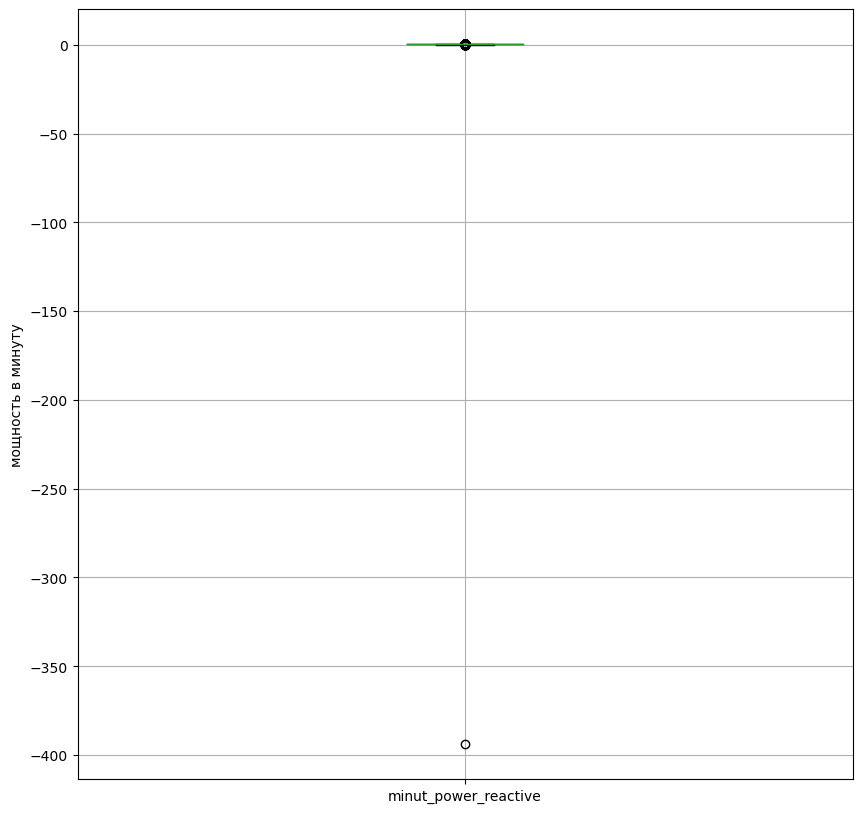

In [48]:
data_arc.boxplot(column='minut_power_reactive')
plt.ylabel('мощность в минуту')
plt.show()

In [49]:
data_arc[data_arc['minut_power_reactive']<0]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second  \
9781  2116  00:44:48  00:46:37     0.495782    -715.504924   109.0   

      minut_power_active  minut_power_reactive  
9781            0.272908           -393.855922

In [50]:
data_arc[data_arc['key']==2116]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second  \
9779  2116  00:29:52  00:31:54     0.433266       0.306141   122.0   
9780  2116  00:35:50  00:38:05     0.620265       0.408352   135.0   
9781  2116  00:44:48  00:46:37     0.495782    -715.504924   109.0   
9782  2116  00:51:51  00:52:58     0.299368       0.198796    67.0   

      minut_power_active  minut_power_reactive  
9779            0.213082              0.150561  
9780            0.275673              0.181490  
9781            0.272908           -393.855922  
9782            0.268090              0.178026

Партия 2116 по позателям заурядная, удалим данные этой партии.

In [51]:
data_arc = data_arc[data_arc['key']!=2116]

Прверим распределение еще раз.

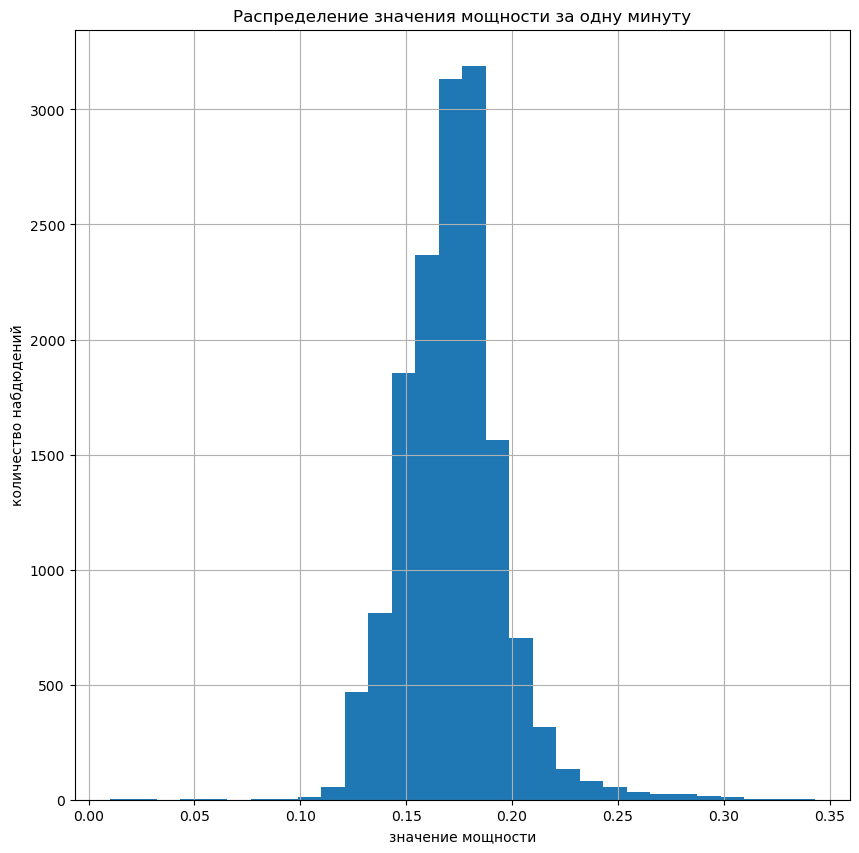

In [52]:
data_arc['minut_power_reactive'].hist(bins=30)
plt.title('Распределение значения мощности за одну минуту')
plt.ylabel('количество набдюдений')
plt.xlabel('значение мощности')
plt.show()

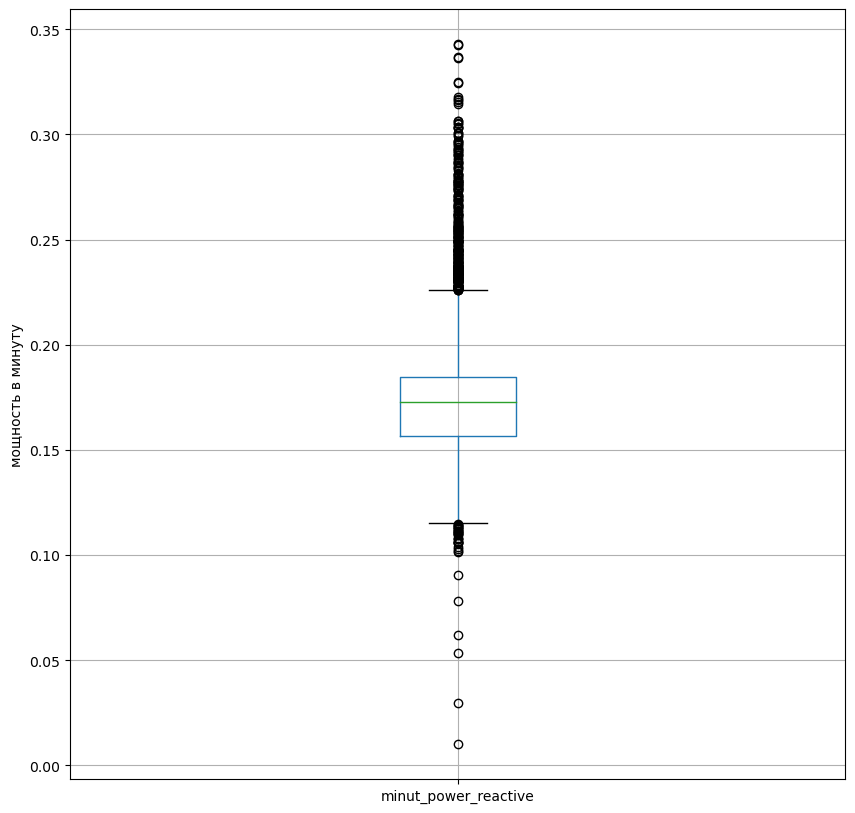

In [53]:
data_arc.boxplot(column='minut_power_reactive')
plt.ylabel('мощность в минуту')
plt.show()

In [54]:
data_arc[data_arc['minut_power_reactive']<0.1]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second  \
2420   521  17:42:57  17:43:11     0.030563       0.021154    14.0   
2451   528  21:36:34  21:42:12     0.246265       0.167929   338.0   
4616   996  22:06:27  22:09:03     0.035165       0.026222   156.0   
4671  1009  09:33:15  09:36:18     0.213525       0.162815   183.0   
6193  1349  02:34:21  02:36:02     0.155590       0.131753   101.0   
8752  1903  05:00:16  05:01:56     0.129953       0.103430   100.0   

      minut_power_active  minut_power_reactive  
2420            0.130984              0.090661  
2451            0.043716              0.029810  
4616            0.013525              0.010085  
4671            0.070008              0.053382  
6193            0.092429              0.078269  
8752            0.077972              0.062058

In [55]:
data_arc[data_arc['key']==996]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second  \
4616  996  22:06:27  22:09:03     0.035165       0.026222   156.0   
4617  996  22:12:05  22:16:19     0.823491       0.651187   254.0   
4618  996  22:34:13  22:35:37     0.336254       0.222117    84.0   

      minut_power_active  minut_power_reactive  
4616            0.013525              0.010085  
4617            0.194526              0.153824  
4618            0.240182              0.158655

Если модель мокажет недостаточный результат вернемся и удалим партии с аномально малой реактивной
мощность за минуту.

Так как в качестве таргета будет выступать конечная температура партии, а из условия задачи
сказанно, что она не сводится к времянным рядам, то агрегируем таблицу по партии и просуммируем
активную и реактивную мощьность, а так же время работы электродов по партиям.

In [56]:
df = data_arc.groupby('key')[['ActivePower','ReactivePower','second']].sum()

In [57]:
df.head()

ActivePower  ReactivePower  second
key                                    
1       4.878147       3.183241  1098.0
2       3.052598       1.998112   811.0
3       2.525882       1.599076   655.0
4       3.209250       2.060298   741.0
5       3.347173       2.252643   869.0

In [58]:
df['second'].max()# Посмотрим максимальное время нагрева с секундах

4189.0

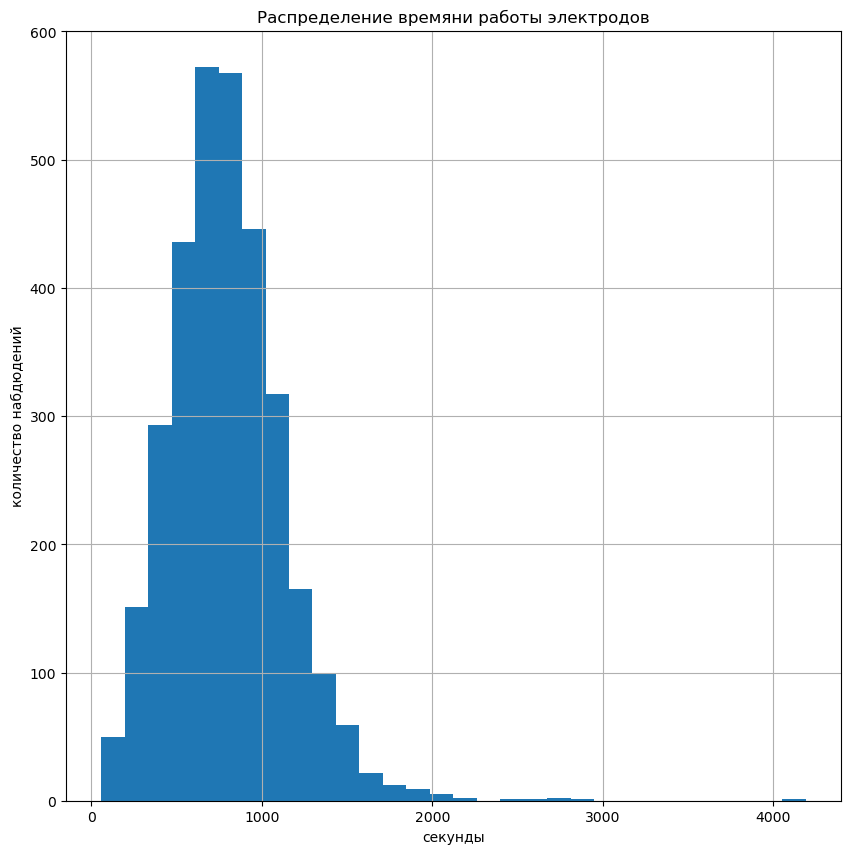

In [59]:
df['second'].hist(bins=30)
plt.title('Распределение времяни работы электродов')
plt.ylabel('количество набдюдений')
plt.xlabel('секунды')
plt.show()

Скомпануем таблмцу df которую в дальнейшем будем объединять с другими таблицами

In [60]:
df = df.join(data_second, how = 'inner')

###### Вывод:
Таблица data_arc переработана. Анамалии и выбросы удалены.

   #### Проанализируем таблицу data_bulk
     Таблица steel.data_bulk
     key — номер партии;
     Bulk1 … Bulk15 — объём подаваемого материала.

In [61]:
df_info(data_bulk, 'data_bulk')

Информация о data_bulk (кол-во столбцов 16, кол-во строк 3129)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5    6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6    7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
7    8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
8    9     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
9   10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5     NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6     NaN      NaN      NaN    204.0      NaN    152.0    154.0  
7     NaN      NaN      NaN    410.0      NaN    252.0    153.0  
8     NaN      NaN      NaN    107.0      NaN     99.0    203.0  
9     NaN      NaN      NaN    203.0      NaN    102.0    204.0

None

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Самый главный столбец с ключами партий не имеет пропусков.

Выясним есть ли строки с отсутсвием информации о добавлении примесей.

In [62]:
data_bulk = data_bulk.fillna(0)# Заменим все Nan на нули 
data_bulk.head(3)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0

Добави мтолбец с суммой примесей, назововем его total_bulk, в партиях где значение столбца total будет равняться
нулю добавок примесей не было, а также возможны выбросы в сторону завышенности количества примесей,
добавим столбец и проанализируем его.

In [63]:
list_bulk =[]#Создадим список столбцов 
for i in data_bulk:
    list_bulk.append(i)
del list_bulk[0]#Удалим из списка столбцов название первого столбца  

In [64]:
data_bulk['total_bulk'] = data_bulk[list_bulk].sum(axis=1)#Посчитаем столбел total
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  total_bulk  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0       553.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0       582.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0       544.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0       595.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0       584.0

Посмотрим диаграму столбца total_bulk

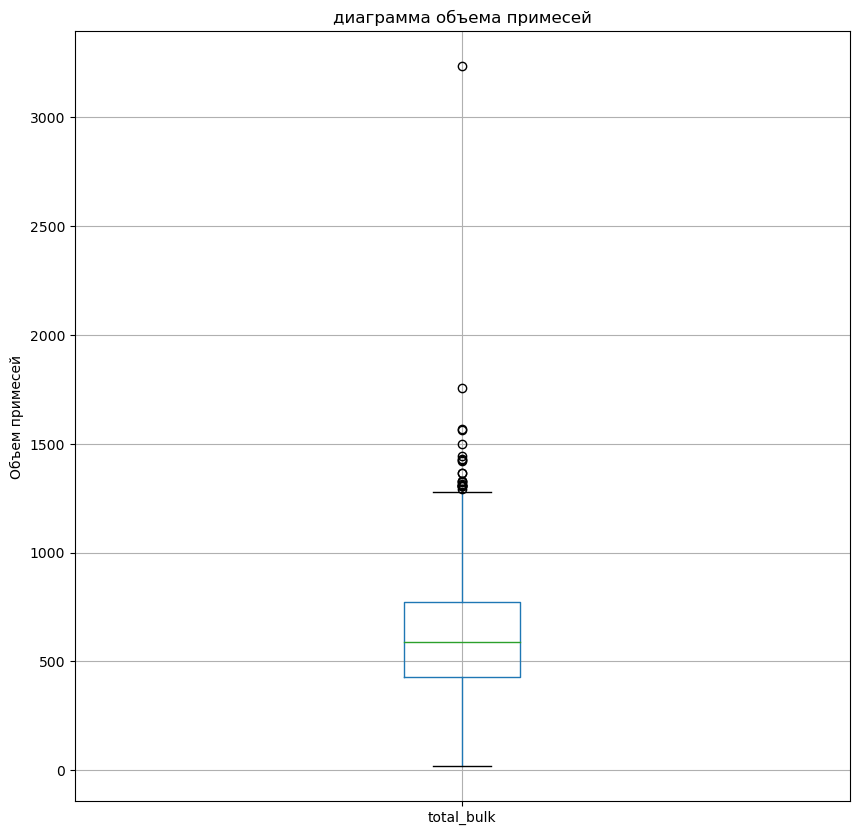

In [65]:
data_bulk.boxplot(column ='total_bulk')
plt.title('диаграмма объема примесей')
plt.ylabel('Объем примесей')
plt.show()

Проанализируем анамалии, по всей видимости свыше 1500 - вполне могут быть выбросами и близкие к нулю
тоже могут быть выбросами.

In [66]:
data_bulk[data_bulk['total_bulk']>1300]

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
11      12    46.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
122    135    48.0     0.0   349.0     0.0     0.0     0.0     0.0     0.0   
207    223     0.0     0.0   124.0     0.0     0.0     0.0     0.0     0.0   
303    322   185.0     0.0   101.0    58.0     0.0     0.0   406.0     0.0   
308    327    67.0     0.0     0.0   119.0     0.0     0.0     0.0     0.0   
418    444    52.0     0.0     0.0   115.0     0.0     0.0     0.0     0.0   
485    512     0.0     0.0    62.0     0.0     0.0   264.0     0.0     0.0   
486    513     0.0     0.0   286.0     0.0     0.0   295.0     0.0     0.0   
871    907     0.0     0.0   202.0     0.0     0.0   157.0     0.0     0.0   
1005  1050    46.0     0.0     0.0     0.0     0.0   109.0     0.0     0.0   
1096  1144     0.0     0.0   395.0     0.0     0.0     0.0     0.0     0.0   
1311  1363     0.0     0.0    85.0     0.0     0.0   283.0     0.0     0.0   
1410  1464    31.0     0.0     0.0   105.0     0.0     0.0     0.0     0.0   
1629  1689     0.0     0.0     0.0     0.0     0.0   247.0     0.0     0.0   
1695  1755     0.0     0.0   206.0     0.0    74.0   236.0     0.0     0.0   
1818  1880     0.0     0.0    20.0     0.0     0.0   164.0     0.0     0.0   
1819  1881     0.0     0.0    29.0     0.0     0.0   330.0     0.0     0.0   
1862  1925     0.0     0.0   445.0     0.0     0.0   204.0     0.0     0.0   
1933  1999    54.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1976  2046     0.0     0.0    80.0   242.0     0.0     0.0     0.0     0.0   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  total_bulk  
11       0.0      0.0      0.0    618.0      0.0    406.0    203.0      1307.0  
122      0.0      0.0      0.0    512.0      0.0    254.0    201.0      1364.0  
207      0.0      0.0      0.0    666.0      0.0    316.0    202.0      1308.0  
303      0.0      0.0      0.0   1849.0      0.0    636.0      0.0      3235.0  
308      0.0      0.0      0.0    775.0      0.0    403.0    205.0      1569.0  
418      0.0      0.0      0.0    671.0      0.0    379.0    203.0      1420.0  
485      0.0      0.0    131.0    528.0      0.0    220.0    225.0      1430.0  
486      0.0      0.0      0.0    474.0      0.0    219.0    224.0      1498.0  
871      0.0      0.0      0.0    410.0      0.0    356.0    206.0      1331.0  
1005     0.0      0.0     29.0    647.0      0.0    371.0    103.0      1305.0  
1096     0.0      0.0      0.0    509.0      0.0    204.0    204.0      1312.0  
1311     0.0      0.0      0.0    411.0      0.0    375.0    210.0      1364.0  
1410     0.0      0.0      0.0    774.0      0.0    306.0    100.0      1316.0  
1629     0.0      0.0      0.0    733.0    305.0    248.0    224.0      1757.0  
1695     0.0      0.0      0.0    408.0      0.0    199.0    205.0      1328.0  
1818     0.0      0.0     19.0    466.0      0.0    450.0    206.0      1325.0  
1819     0.0      0.0    198.0    462.0      0.0    201.0    206.0      1426.0  
1862     0.0      0.0      0.0    205.0      0.0    348.0    104.0      1306.0  
1933     0.0      0.0      0.0    853.0      0.0    366.0    290.0      1563.0  
1976     0.0      0.0      0.0    620.0      0.0    292.0    209.0      1443.0

In [67]:
list_part_bulk = list(data_bulk[data_bulk['total_bulk']>1300]['key'])#создадим список с анамальными партиями

Посмотрим на партию с анамально большим добавлением примсей номер 303.

In [68]:
data_arc[data_arc['key']==303]

key BeginHeat   EndHeat  ActivePower  ReactivePower  second  \
1395  303  16:19:59  16:23:17     0.750546       0.516991   198.0   
1396  303  16:25:16  16:30:24     1.154146       0.848795   308.0   
1397  303  16:39:20  16:42:35     0.772318       0.558077   195.0   
1398  303  16:50:28  16:53:01     0.580163       0.465469   153.0   
1399  303  16:55:51  16:58:58     0.807359       0.573469   187.0   

      minut_power_active  minut_power_reactive  
1395            0.227438              0.156664  
1396            0.224834              0.165350  
1397            0.237636              0.171716  
1398            0.227515              0.182537  
1399            0.259046              0.184001

In [69]:
df_bulk = data_bulk.set_index('key')

Объединим таблицы df(агрегированная информация по партиям) и df_bulk(информация о добавлении примесей)

In [70]:
len(df_bulk)

3129

In [71]:
data = df.join(df_bulk, how ='inner')

In [72]:
data.isna().sum()

ActivePower      0
ReactivePower    0
second           0
tot_second       0
haur             0
Bulk 1           0
Bulk 2           0
Bulk 3           0
Bulk 4           0
Bulk 5           0
Bulk 6           0
Bulk 7           0
Bulk 8           0
Bulk 9           0
Bulk 10          0
Bulk 11          0
Bulk 12          0
Bulk 13          0
Bulk 14          0
Bulk 15          0
total_bulk       0
dtype: int64

###### Вывод:
Таблица data_bulk переработана. Анамалии и выбросы удалены.

##### Анализ таблицы data_bulk_time

Таблица steel.data_bulk_time
key — номер партии;
Bulk1 … Bulk15 — время подачи материала.

In [73]:
df_info(data_bulk_time, 'data_bulk_time')

Информация о data_bulk_time (кол-во столбцов 16, кол-во строк 3129)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


key Bulk 1 Bulk 2 Bulk 3    Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1   None   None   None  11:21:30   None   None   None   None   None   
1    2   None   None   None  11:46:38   None   None   None   None   None   
2    3   None   None   None  12:31:06   None   None   None   None   None   
3    4   None   None   None  12:48:43   None   None   None   None   None   
4    5   None   None   None  13:18:50   None   None   None   None   None   
5    6   None   None   None  13:59:24   None   None   None   None   None   
6    7   None   None   None  14:29:14   None   None   None   None   None   
7    8   None   None   None  15:04:05   None   None   None   None   None   
8    9   None   None   None  15:47:34   None   None   None   None   None   
9   10   None   None   None      None   None   None   None   None   None   

  Bulk 10 Bulk 11   Bulk 12 Bulk 13   Bulk 14   Bulk 15  
0    None    None  11:03:52    None  11:03:52  11:03:52  
1    None    None  11:40:20    None  11:40:20  11:40:20  
2    None    None  12:09:40    None  12:09:40  12:09:40  
3    None    None  12:41:24    None  12:41:24  12:41:24  
4    None    None  13:12:56    None  13:12:56  13:12:56  
5    None    None  13:53:27    None  13:53:27  13:53:27  
6    None    None  14:22:19    None  14:22:19  14:22:19  
7    None    None  14:55:46    None  14:55:46  14:55:46  
8    None    None  15:41:00    None  15:41:00  15:41:00  
9    None    None  16:18:52    None  16:18:52  16:18:52

None

key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

В таблице data_bulk_time преобразуем данные с расчетом от времяни начала первого нагрева, посчитаем
его в секундах.

In [74]:
data_bulk_time = data_bulk_time.join(data_arc.groupby('key')['BeginHeat'].first().to_frame(), how = 'inner')

In [75]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3    Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
1    2   None   None   None  11:46:38   None   None   None   None   None   
2    3   None   None   None  12:31:06   None   None   None   None   None   
3    4   None   None   None  12:48:43   None   None   None   None   None   
4    5   None   None   None  13:18:50   None   None   None   None   None   
5    6   None   None   None  13:59:24   None   None   None   None   None   

  Bulk 10 Bulk 11   Bulk 12 Bulk 13   Bulk 14   Bulk 15 BeginHeat  
1    None    None  11:40:20    None  11:40:20  11:40:20  11:02:14  
2    None    None  12:09:40    None  12:09:40  12:09:40  11:34:14  
3    None    None  12:41:24    None  12:41:24  12:41:24  12:06:54  
4    None    None  13:12:56    None  13:12:56  13:12:56  12:39:37  
5    None    None  13:53:27    None  13:53:27  13:53:27  13:11:13

In [76]:
data_bulk_time = data_bulk_time.fillna(0)# Заменим все Nan на нули 
data_bulk_time = data_bulk_time.set_index('key')# 
data_bulk_time.head(3)

Bulk 1 Bulk 2 Bulk 3    Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10  \
key                                                                             
2        0      0      0  11:46:38      0      0      0      0      0       0   
3        0      0      0  12:31:06      0      0      0      0      0       0   
4        0      0      0  12:48:43      0      0      0      0      0       0   

    Bulk 11   Bulk 12 Bulk 13   Bulk 14   Bulk 15 BeginHeat  
key                                                          
2         0  11:40:20       0  11:40:20  11:40:20  11:02:14  
3         0  12:09:40       0  12:09:40  12:09:40  11:34:14  
4         0  12:41:24       0  12:41:24  12:41:24  12:06:54

In [77]:
for i in list_bulk:
    for j in data_bulk_time.index:
        if data_bulk_time[i][j]!=0:
            data_bulk_time[i][j] = ((pd.to_datetime(data_bulk_time[i][j], format='%H:%M:%S'))-\
                                    (pd.to_datetime(data_bulk_time['BeginHeat'][j], format='%H:%M:%S'))).total_seconds()

Так как работа предмприятия круглосуточная, то в таблице присутствуют значения времяни с
отрецательным знаком, преобразуем эти значения прибавив количество секунд в сутках.

In [78]:
for i in list_bulk:
    data_bulk_time.loc[(data_bulk_time[i]<0), i] = data_bulk_time[i]+86400

Проверим есть ли такие строки где время подачи материала анамально завышина. 
В процессе анализа данных я заметил, что обработка некоторых партий занимантвремя до 
5 часов, но подача мариала не может измеряться сутками.

In [79]:
data_bulk_time[data_bulk_time['Bulk 15']>7200]#data_bulk_time.columns[:15]

Bulk 1 Bulk 2   Bulk 3 Bulk 4 Bulk 5   Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
key                                                                         
43          0      0   9008.0      0      0        0      0      0      0   
46          0      0        0      0      0  16567.0      0      0      0   
47          0      0        0      0      0  11695.0      0      0      0   
57    30523.0      0        0      0      0  31480.0      0      0      0   
58    26159.0      0        0      0      0  26377.0      0      0      0   
...       ...    ...      ...    ...    ...      ...    ...    ...    ...   
3237        0      0  52473.0      0      0        0      0      0      0   
3238        0      0  53417.0      0      0        0      0      0      0   
3239        0      0        0      0      0  54668.0      0      0      0   
3240        0      0        0      0      0  56045.0      0      0      0   
3241        0      0        0      0      0        0      0      0      0   

     Bulk 10 Bulk 11  Bulk 12 Bulk 13  Bulk 14  Bulk 15 BeginHeat  
key                                                                
43         0       0   8365.0       0   8365.0   8365.0  18:03:59  
46         0       0  16122.0       0  13493.0  16122.0  20:15:41  
47         0       0  11476.0       0  11476.0  11476.0  22:09:23  
57         0       0  30139.0       0  30139.0  30139.0  01:40:30  
58         0       0  25773.0       0  25773.0  25773.0  03:45:43  
...      ...     ...      ...     ...      ...      ...       ...  
3237       0       0  52197.0       0  52197.0  52197.0  08:16:55  
3238       0       0  53055.0       0  53055.0  53055.0  08:48:54  
3239       0       0  53931.0       0  53555.0  53555.0  10:40:50  
3240       0       0        0       0  54172.0  54172.0  11:38:35  
3241       0       0        0       0  57029.0  57029.0  12:15:05  

[2019 rows x 16 columns]

In [80]:
data_arc[data_arc['key']==44]#данная партия начинает обрабатываться 22:09, а заканчивается 1:10 

key BeginHeat   EndHeat  ActivePower  ReactivePower  second  \
190   44  22:09:23  22:11:49     0.514491       0.406311   146.0   
191   44  22:14:17  22:17:39     0.691813       0.554531   202.0   
192   44  22:19:54  22:24:09     0.927365       0.654955   255.0   
193   44  22:30:57  22:31:39     0.155866       0.112500    42.0   
194   44  22:32:45  22:34:57     0.501012       0.339709   132.0   
195   44  22:44:58  22:46:04     0.253021       0.163590    66.0   
196   44  22:47:31  22:49:34     0.489501       0.352497   123.0   
197   44  00:32:02  00:34:36     0.537892       0.426978   154.0   
198   44  00:36:13  00:46:45     2.343373       1.921817   632.0   
199   44  00:49:21  00:52:55     0.832662       0.637833   214.0   
200   44  01:04:04  01:04:31     0.098206       0.079758    27.0   
201   44  01:10:03  01:11:13     0.267416       0.211502    70.0   

     minut_power_active  minut_power_reactive  
190            0.211435              0.166977  
191            0.205489              0.164712  
192            0.218203              0.154107  
193            0.222665              0.160714  
194            0.227733              0.154413  
195            0.230020              0.148718  
196            0.238781              0.171950  
197            0.209568              0.166355  
198            0.222472              0.182451  
199            0.233457              0.178832  
200            0.218236              0.177239  
201            0.229213              0.181287

В партиях где время подачи исчесляется сутками заменим на нуль, так как это связанно
с асинхнонностью часов в оборудовании, на самом деле подача материала началась практически
в месте с нагревом.

In [81]:
for i in list_bulk:
    data_bulk_time.loc[(data_bulk_time[i]>12500), i] = 0

In [82]:
data_bulk_time[data_bulk_time['Bulk 15']>7200]

Bulk 1 Bulk 2  Bulk 3   Bulk 4 Bulk 5   Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
key                                                                          
43          0      0  9008.0        0      0        0      0      0      0   
47          0      0       0        0      0  11695.0      0      0      0   
358         0      0       0        0      0   8356.0      0      0      0   
360         0      0       0  12486.0      0        0      0      0      0   
361   11297.0      0       0  11448.0      0        0      0      0      0   
...       ...    ...     ...      ...    ...      ...    ...    ...    ...   
2535        0      0       0        0      0   8361.0      0      0      0   
2542        0      0       0        0      0        0      0      0      0   
2829        0      0       0  10588.0      0        0      0      0      0   
2830        0      0  9438.0        0      0        0      0      0      0   
2831        0      0  7958.0        0      0        0      0      0      0   

     Bulk 10 Bulk 11  Bulk 12 Bulk 13  Bulk 14  Bulk 15 BeginHeat  
key                                                                
43         0       0   8365.0       0   8365.0   8365.0  18:03:59  
47         0       0  11476.0       0  11476.0  11476.0  22:09:23  
358        0  8450.0   7916.0       0   7916.0   7916.0  20:10:21  
360        0       0  11983.0       0  11983.0  11983.0  22:13:38  
361        0       0  10386.0       0  10386.0  10386.0  23:32:12  
...      ...     ...      ...     ...      ...      ...       ...  
2535       0       0   8067.0       0   8067.0   8067.0  03:33:45  
2542       0       0        0       0  12199.0  12199.0  08:28:28  
2829       0       0   7225.0       0   7225.0   7225.0  00:24:04  
2830       0       0   8947.0       0   8947.0   8947.0  01:15:12  
2831       0       0   7689.0       0   7689.0   7689.0  02:09:14  

[152 rows x 16 columns]

In [83]:
data_bulk_time = data_bulk_time.drop('BeginHeat', axis =1)#head()

In [84]:
data_bulk_time.head()

Bulk 1 Bulk 2 Bulk 3  Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10  \
key                                                                           
2        0      0      0  2664.0      0      0      0      0      0       0   
3        0      0      0  3412.0      0      0      0      0      0       0   
4        0      0      0  2509.0      0      0      0      0      0       0   
5        0      0      0  2353.0      0      0      0      0      0       0   
6        0      0      0  2891.0      0      0      0      0      0       0   

    Bulk 11 Bulk 12 Bulk 13 Bulk 14 Bulk 15  
key                                          
2         0  2286.0       0  2286.0  2286.0  
3         0  2126.0       0  2126.0  2126.0  
4         0  2070.0       0  2070.0  2070.0  
5         0  1999.0       0  1999.0  1999.0  
6         0  2534.0       0  2534.0  2534.0

Получили таблицу data_bulk_time, где в столбцах указанно время в секундах через которое
от начала первого нагрева были добавленны примеси.

Чтобы соединить таблицы не должно быть одинаковых названий столбцов, так как общая таблица
должна включать в себя информацию не только о количестве смесей, но и время подачи от
начала нагрева в секундах. Заменим название столбцов таблицы data_bulk_time.

In [85]:
data_bulk_time = data_bulk_time.set_axis(['bulk 1','bulk 2','bulk 3','bulk 4','bulk 5','bulk 6',\
                                          'bulk 7','bulk 8','bulk 9','bulk 10',\
                         'bulk 11','bulk 12','bulk 13','bulk 14','bulk 15'], axis = 1)

In [86]:
data = data.join(data_bulk_time, how = 'inner')#Присоединим таблицу data_bulk_time

##### Проанализируем таблицу с объемом подаваемого газа. 

Таблица steel.data_gas
key — номер партии;
gas — объём подаваемого газа.

In [87]:
df_info(data_gas, 'data_gas')

Информация о data_gas (кол-во столбцов 2, кол-во строк 3239)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


key        gas
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
5    6  11.273392
6    7   9.836267
7    8  15.171553
8    9   8.216623
9   10   6.529891

None

key          gas
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

key    0
gas    0
dtype: int64

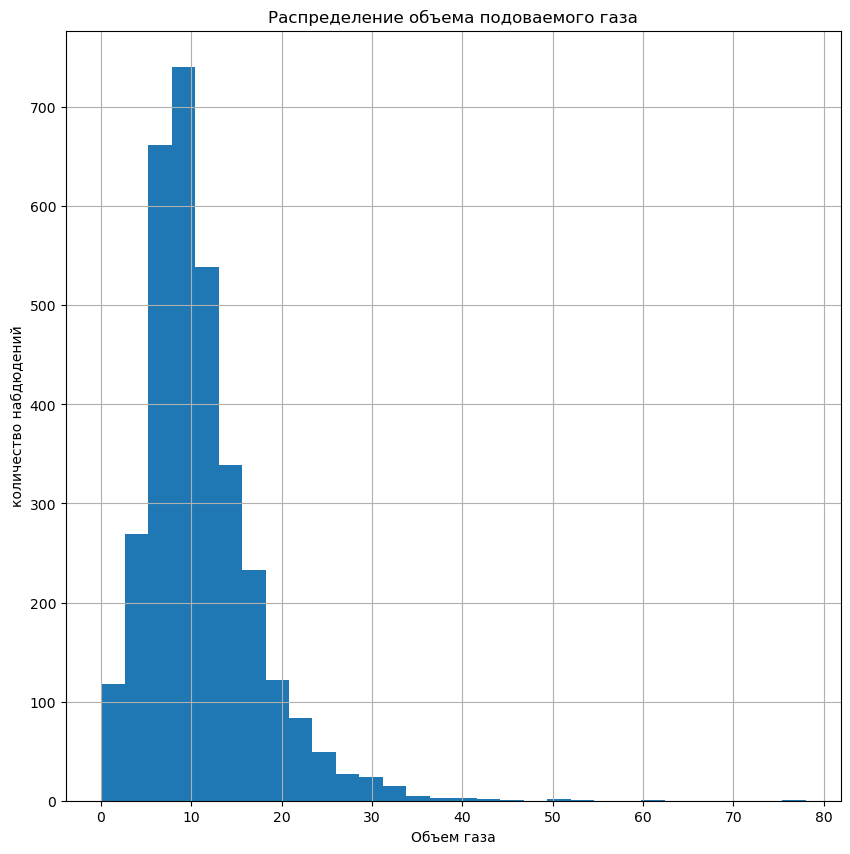

In [88]:
data_gas['gas'].hist(bins =30)
plt.title('Распределение объема подоваемого газа')
plt.ylabel('количество набдюдений')
plt.xlabel('Объем газа')
plt.show()


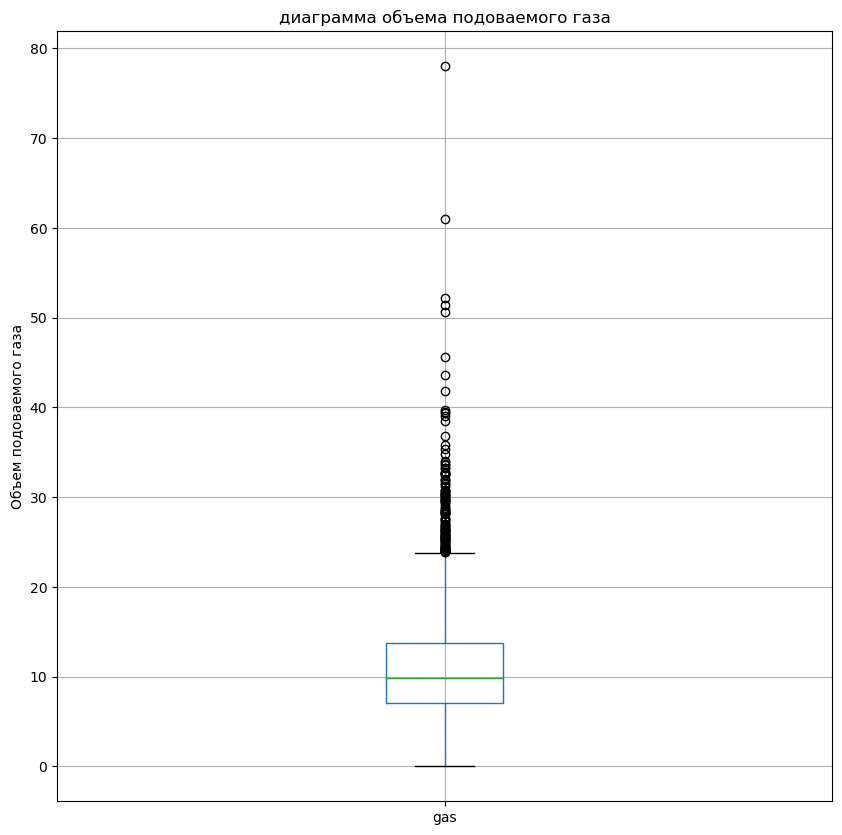

In [89]:
data_gas.boxplot(column ='gas')
plt.title('диаграмма объема подоваемого газа')
plt.ylabel('Объем подоваемого газа')
plt.show()

Выше 40 похоже на выбросы.

In [90]:
data_gas[data_gas['gas']>40]

key        gas
116    117  50.581035
277    280  60.935689
319    322  77.995040
660    663  41.854643
1461  1464  43.655411
2105  2108  45.638999
2107  2110  52.142373
2567  2570  51.380229

In [91]:
data_gas[data_gas['gas']<0.5]

key       gas
193    195  0.374436
352    355  0.325733
537    540  0.469567
863    866  0.008399
951    954  0.364256
1044  1047  0.016696
1130  1133  0.364789
1297  1300  0.497964
2100  2103  0.263029
2353  2356  0.275081
2466  2469  0.335164
2488  2491  0.382644
2680  2683  0.338997

Не будем удалять подозрительные данные, хотя они явно похожи ка выбросы.

In [92]:
#data_gas = data_gas[(data_gas['gas']>0.5) & (data_gas['gas']<40)]

In [93]:
data_gas = data_gas.set_index('key')

In [94]:
data = data.join(data_gas, how = 'inner')

In [95]:
data.head()

ActivePower  ReactivePower  second  tot_second  haur  Bulk 1  Bulk 2  \
key                                                                         
2       3.052598       1.998112   811.0      1144.0  0.32     0.0     0.0   
3       2.525882       1.599076   655.0      1525.0  0.42     0.0     0.0   
4       3.209250       2.060298   741.0      1093.0  0.30     0.0     0.0   
5       3.347173       2.252643   869.0      1362.0  0.38     0.0     0.0   
6       3.955108       2.689175   952.0      1353.0  0.38     0.0     0.0   

     Bulk 3  Bulk 4  Bulk 5  ...  bulk 7  bulk 8  bulk 9  bulk 10  bulk 11  \
key                          ...                                             
2       0.0    73.0     0.0  ...       0       0       0        0        0   
3       0.0    34.0     0.0  ...       0       0       0        0        0   
4       0.0    81.0     0.0  ...       0       0       0        0        0   
5       0.0    78.0     0.0  ...       0       0       0        0        0   
6       0.0   117.0     0.0  ...       0       0       0        0        0   

     bulk 12  bulk 13  bulk 14  bulk 15        gas  
key                                                 
2     2286.0        0   2286.0   2286.0  12.555561  
3     2126.0        0   2126.0   2126.0  28.554793  
4     2070.0        0   2070.0   2070.0  18.841219  
5     1999.0        0   1999.0   1999.0   5.413692  
6     2534.0        0   2534.0   2534.0  11.273392  

[5 rows x 37 columns]

###### Вывод:
Таблица data_gas переработана. Анамалии и выбросы удалены.

##### Проанализируем таблицу data_wire

Таблица steel.data_wire
key — номер партии;
Wire1 … Wire15 — объём подаваемых проволочных материалов.

In [96]:
df_info(data_wire, 'data_wire')

Информация о data_wire (кол-во столбцов 10, кол-во строк 3081)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1   60.059998        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2   96.052315        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3   91.160157        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4   89.063515        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5   89.238236   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
5    6   99.109917   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
6    7   98.061600        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7    8  155.282394        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8    9  113.393279   9.143681     NaN     NaN     NaN     NaN     NaN     NaN   
9   10   81.244796  12.376000     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN

None

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060484    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Посмотрим на распределение объема проволочных материалов по партиям. 

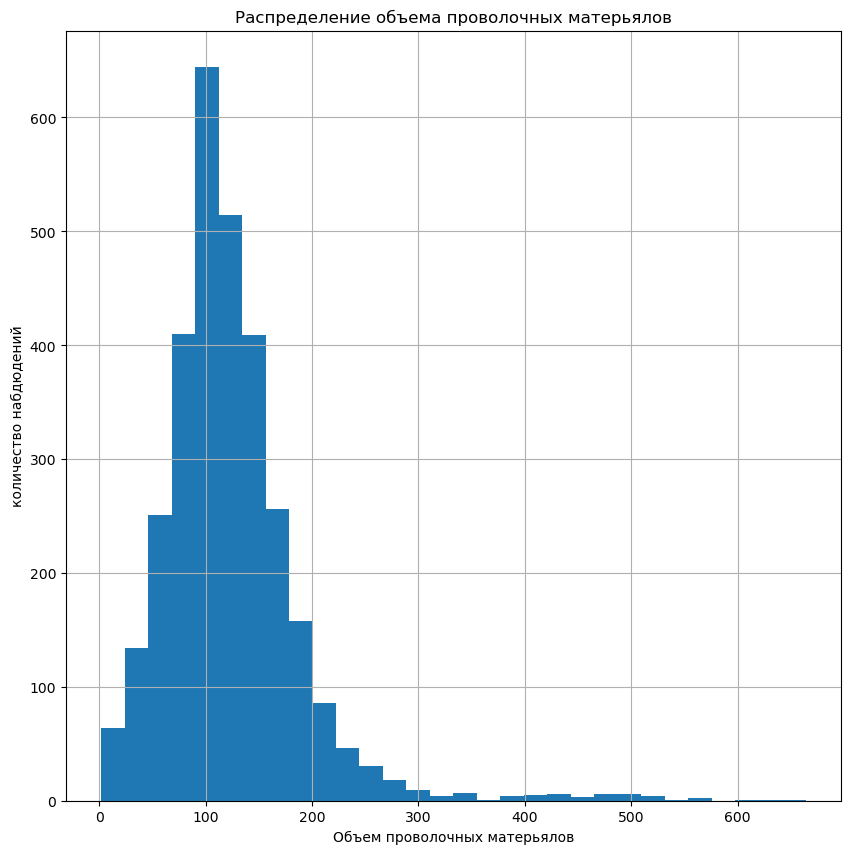

In [97]:
data_wire[data_wire.columns[1:]].sum(axis=1).hist(bins = 30)
plt.title('Распределение объема проволочных матерьялов')
plt.ylabel('количество набдюдений')
plt.xlabel('Объем проволочных матерьялов')
plt.show()

In [98]:
data_wire['total_wire'] = data_wire[data_wire.columns[1:]].sum(axis=1)

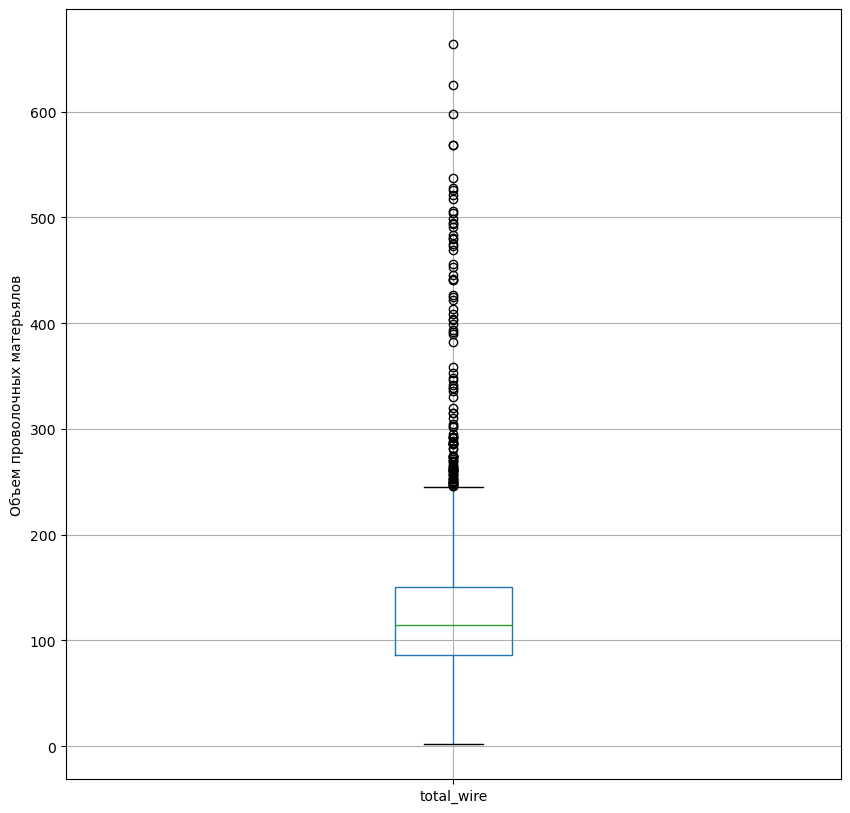

In [99]:
data_wire.boxplot(column='total_wire')
plt.ylabel('Объем проволочных матерьялов')
plt.show()

In [100]:
data_wire[data_wire['total_wire']>550]

key      Wire 1      Wire 2      Wire 3  Wire 4  Wire 5  Wire 6  \
1750  1840  200.210403   80.135117  288.432144     NaN     NaN     NaN   
1825  1915  161.091842   22.137440  385.008668     NaN     NaN     NaN   
2374  2501  172.754410  198.452789  254.462219     NaN     NaN     NaN   
2381  2508  175.637275  219.866410  268.348081     NaN     NaN     NaN   
2759  2912  190.095352   80.346243  327.233753     NaN     NaN     NaN   

      Wire 7  Wire 8  Wire 9  total_wire  
1750     NaN     NaN     NaN  568.777664  
1825     NaN     NaN     NaN  568.237950  
2374     NaN     NaN     NaN  625.669418  
2381     NaN     NaN     NaN  663.851766  
2759     NaN     NaN     NaN  597.675348

In [101]:
data_wire[data_wire['total_wire']<5]

key   Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
1381  1453  1.91880     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3054  3215  4.06224     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 9  total_wire  
1381     NaN     1.91880  
3054     NaN     4.06224

Удалим подозрительные данные.

In [102]:
data_wire = data_wire[(data_wire['total_wire']<550) & (data_wire['total_wire']>5)]

In [103]:
data_wire = data_wire.fillna(0)
data_wire = data_wire.set_index('key')
data_wire.head()

Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
key                                                                       
1    60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
5    89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

     Wire 9  total_wire  
key                      
1       0.0   60.059998  
2       0.0   96.052315  
3       0.0   91.160157  
4       0.0   89.063515  
5       0.0   98.352796

In [104]:
data = data.join(data_wire, how = 'inner')

##### Проведем анализ таблицы data_wire_time

Таблица steel.data_wire_time
Key — номер партии;
Wire1 … Wire15 — время подачи проволочных материалов.

In [105]:
df_info(data_wire_time, 'data_wire_time')

Информация о data_wire_time (кол-во столбцов 10, кол-во строк 3081)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


key    Wire 1    Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
0    1  11:11:41      None   None   None   None   None   None   None   None
1    2  11:46:10      None   None   None   None   None   None   None   None
2    3  12:13:47      None   None   None   None   None   None   None   None
3    4  12:48:05      None   None   None   None   None   None   None   None
4    5  13:18:15  13:32:06   None   None   None   None   None   None   None
5    6  13:59:02  13:59:54   None   None   None   None   None   None   None
6    7  14:28:46      None   None   None   None   None   None   None   None
7    8  15:03:42      None   None   None   None   None   None   None   None
8    9  15:42:43  15:58:12   None   None   None   None   None   None   None
9   10  16:20:25  16:21:02   None   None   None   None   None   None   None

None

key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

В таблице data_wire_time преобразуем данные с расчетом от времяни начала первого нагрева, посчитаем
его в секундах.

In [106]:
data_wire_time =  data_wire_time.fillna(0)
data_wire_time = data_wire_time.set_index('key')
data_wire_time.head()

Wire 1    Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
key                                                                     
1    11:11:41         0      0      0      0      0      0      0      0
2    11:46:10         0      0      0      0      0      0      0      0
3    12:13:47         0      0      0      0      0      0      0      0
4    12:48:05         0      0      0      0      0      0      0      0
5    13:18:15  13:32:06      0      0      0      0      0      0      0

In [107]:
data_wire_time = data_wire_time.join(data_arc.groupby('key')['BeginHeat'].first().to_frame(), how='inner')

In [108]:
data_wire_time.head()

Wire 1    Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9  \
key                                                                        
1    11:11:41         0      0      0      0      0      0      0      0   
2    11:46:10         0      0      0      0      0      0      0      0   
3    12:13:47         0      0      0      0      0      0      0      0   
4    12:48:05         0      0      0      0      0      0      0      0   
5    13:18:15  13:32:06      0      0      0      0      0      0      0   

    BeginHeat  
key            
1    11:02:14  
2    11:34:14  
3    12:06:54  
4    12:39:37  
5    13:11:13

In [109]:
data_wire_time.columns[:9]

Index(['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9'],
      dtype='object')

In [110]:
for i in data_wire_time.columns[:9]:
    for j in data_wire_time.index:
        if data_wire_time[i][j]!=0:
            data_wire_time[i][j] = ((pd.to_datetime(data_wire_time[i][j], format='%H:%M:%S'))-\
                                    (pd.to_datetime(data_wire_time['BeginHeat'][j], format='%H:%M:%S'))).total_seconds()

В партиях где время подачи исчесляется сутками заменим на нуль, так как это связанно
с асинхнонностью часов в оборудовании, на самом деле подача материала началась практически
в месте с нагревом.

In [111]:
for i in data_wire_time.columns[:9]:
    data_wire_time.loc[(data_wire_time[i]<0), i] = data_wire_time[i]+86400
    data_wire_time.loc[(data_wire_time[i]>12500), i] = 0# Заменим анамально большое время на 0

In [112]:
data_wire_time = data_wire_time.drop('BeginHeat', axis = 1)
data_wire_time

Wire 1  Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
key                                                                  
1      567.0       0      0      0      0      0      0      0      0
2      716.0       0      0      0      0      0      0      0      0
3      413.0       0      0      0      0      0      0      0      0
4      508.0       0      0      0      0      0      0      0      0
5      422.0  1253.0      0      0      0      0      0      0      0
...      ...     ...    ...    ...    ...    ...    ...    ...    ...
3237   542.0       0      0      0      0      0      0      0      0
3238   726.0       0      0      0      0      0      0      0      0
3239  1430.0       0      0      0      0      0      0      0      0
3240  2198.0       0      0      0      0      0      0      0      0
3241  1023.0       0      0      0      0      0      0      0      0

[3079 rows x 9 columns]

Изменим название столбцов таблицы data_wire_time, что бы присоединить к общей таблице.

In [113]:
data_wire_time = data_wire_time.set_axis(['wire 1','wire 2','wire 3','wire 4','wire 5','wire 6',\
                                          'wire 7','wire 8','wire 9'], axis = 1)

In [114]:
data = data.join(data_wire_time, how = 'inner')

In [115]:
data.head()

ActivePower  ReactivePower  second  tot_second  haur  Bulk 1  Bulk 2  \
key                                                                         
2       3.052598       1.998112   811.0      1144.0  0.32     0.0     0.0   
3       2.525882       1.599076   655.0      1525.0  0.42     0.0     0.0   
4       3.209250       2.060298   741.0      1093.0  0.30     0.0     0.0   
5       3.347173       2.252643   869.0      1362.0  0.38     0.0     0.0   
6       3.955108       2.689175   952.0      1353.0  0.38     0.0     0.0   

     Bulk 3  Bulk 4  Bulk 5  ...  total_wire  wire 1  wire 2  wire 3  wire 4  \
key                          ...                                               
2       0.0    73.0     0.0  ...   96.052315   716.0       0       0       0   
3       0.0    34.0     0.0  ...   91.160157   413.0       0       0       0   
4       0.0    81.0     0.0  ...   89.063515   508.0       0       0       0   
5       0.0    78.0     0.0  ...   98.352796   422.0  1253.0       0       0   
6       0.0   117.0     0.0  ...  108.224477   731.0   783.0       0       0   

     wire 5  wire 6  wire 7  wire 8  wire 9  
key                                          
2         0       0       0       0       0  
3         0       0       0       0       0  
4         0       0       0       0       0  
5         0       0       0       0       0  
6         0       0       0       0       0  

[5 rows x 56 columns]

##### Проведем анализ и агрегирование таблицы data_temp

Таблица steel.data_temp
key — номер партии;
MesaureTime — время замера;
Temperature — значение температуры.

In [116]:
df_info(data_temp, 'data_temp')

Информация о data_temp (кол-во столбцов 3, кол-во строк 15907)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


key MesaureTime  Temperature
0    1    11:16:18       1571.0
1    1    11:25:53       1604.0
2    1    11:29:11       1618.0
3    1    11:30:01       1601.0
4    1    11:30:39       1613.0
5    2    11:37:27       1581.0
6    2    11:38:00       1577.0
7    2    11:49:38       1589.0
8    2    11:55:50       1604.0
9    2    11:58:24       1608.0

None

key   Temperature
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

key               0
MesaureTime       0
Temperature    2901
dtype: int64

В техническом задании было сказанно, что заказщик считает температуру ниже 1500 градусов аномальной.
Проанализируем столбец с замероми температуры. Удалим из таблицы аномальные значения.

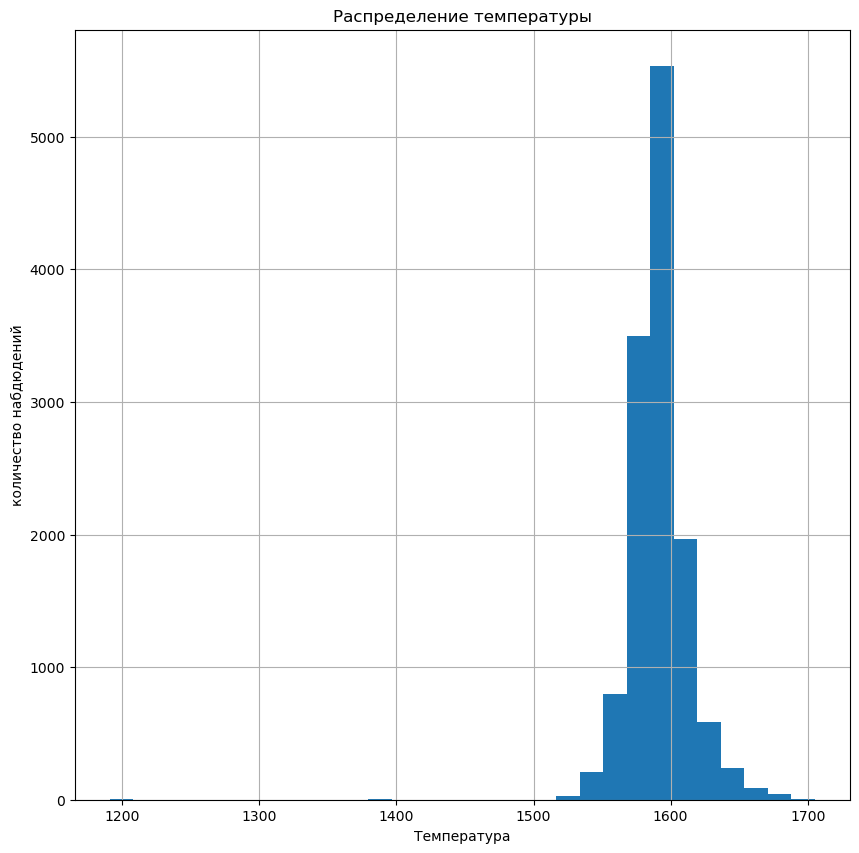

In [117]:
data_temp['Temperature'].hist(bins = 30)
plt.title('Распределение температуры')
plt.ylabel('количество набдюдений')
plt.xlabel('Температура')
plt.show()

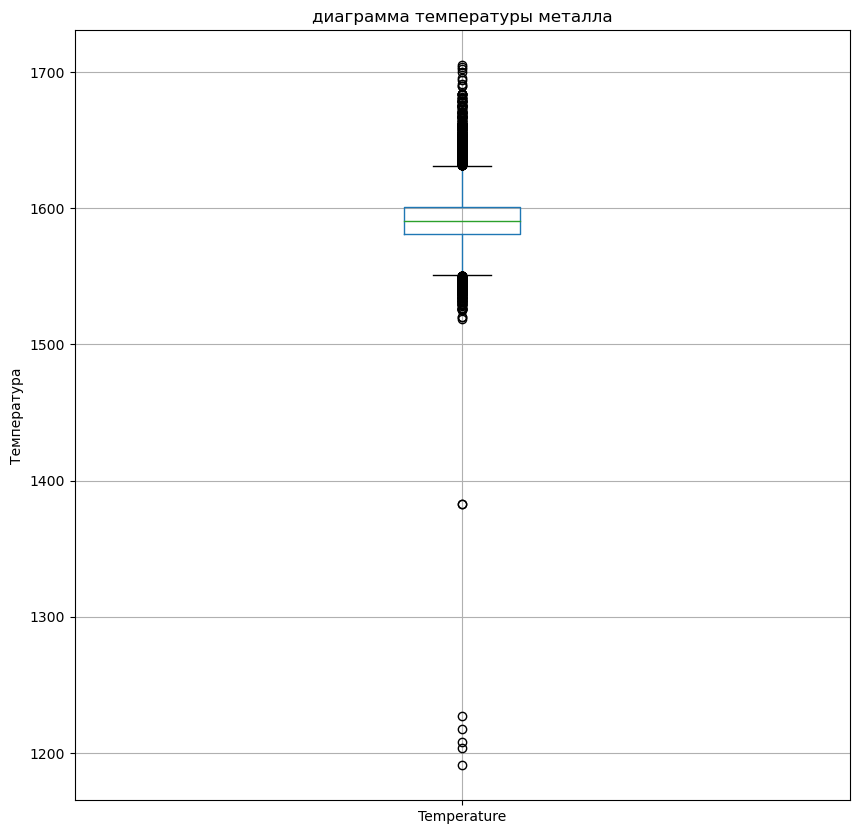

In [118]:
data_temp.boxplot(column='Temperature')
plt.title('диаграмма температуры металла')
plt.ylabel('Температура')
plt.show()

Изучим пропуски таблицы data_temp и удалим партии в которых есть хотябы один пропуск.

In [119]:
data_temp.isna().sum()

key               0
MesaureTime       0
Temperature    2901
dtype: int64

Создадим список серий где хотябы один раз встречается пропуск значения температуры.
Удалим серии с пропусками.
Удалим партии с анамально низкой температурой.

In [120]:
dpop = list(data_temp[data_temp['Temperature'].isna()==True]['key'].unique())
data_temp = data_temp[data_temp['key'].isin(dpop) == False]
drop1 = list(data_temp[data_temp['Temperature']<1500]['key'].unique())
data_temp = data_temp[data_temp['key'].isin(drop1) == False]
last = data_temp.groupby('key')['Temperature'].last().to_frame().set_axis(['last_temp'], axis = 1)
first = data_temp.groupby('key')['Temperature'].first().to_frame().set_axis(['first_temp'], axis = 1)

В таблице data_temp в столце Temperature 2901 пропуск, но нас интерисует начальная и конечная
температура партии. Агрегируем таблицу чтобы в ней отображалась начальная и конечная температура
партий. Любые другие промежуточные значения температуры приведут к утечке целевого признака, 
их нельзя использовать как входные.

Удалим партии с анамально низкой температурой. 

In [121]:
data_temp_select = first.join(last)

In [122]:
data_temp_select.isna().sum()

first_temp    0
last_temp     0
dtype: int64

In [123]:
data = data.join(data_temp_select, how = 'inner')

In [124]:
data.duplicated().sum()# Проверим наличие дубликатов

0

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2301 entries, 2 to 2499
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    2301 non-null   float64
 1   ReactivePower  2301 non-null   float64
 2   second         2301 non-null   float64
 3   tot_second     2301 non-null   float64
 4   haur           2301 non-null   float64
 5   Bulk 1         2301 non-null   float64
 6   Bulk 2         2301 non-null   float64
 7   Bulk 3         2301 non-null   float64
 8   Bulk 4         2301 non-null   float64
 9   Bulk 5         2301 non-null   float64
 10  Bulk 6         2301 non-null   float64
 11  Bulk 7         2301 non-null   float64
 12  Bulk 8         2301 non-null   float64
 13  Bulk 9         2301 non-null   float64
 14  Bulk 10        2301 non-null   float64
 15  Bulk 11        2301 non-null   float64
 16  Bulk 12        2301 non-null   float64
 17  Bulk 13        2301 non-null   float64
 18  Bulk 14      

In [126]:
data.isna().sum()

ActivePower      0
ReactivePower    0
second           0
tot_second       0
haur             0
Bulk 1           0
Bulk 2           0
Bulk 3           0
Bulk 4           0
Bulk 5           0
Bulk 6           0
Bulk 7           0
Bulk 8           0
Bulk 9           0
Bulk 10          0
Bulk 11          0
Bulk 12          0
Bulk 13          0
Bulk 14          0
Bulk 15          0
total_bulk       0
bulk 1           0
bulk 2           0
bulk 3           0
bulk 4           0
bulk 5           0
bulk 6           0
bulk 7           0
bulk 8           0
bulk 9           0
bulk 10          0
bulk 11          0
bulk 12          0
bulk 13          0
bulk 14          0
bulk 15          0
gas              0
Wire 1           0
Wire 2           0
Wire 3           0
Wire 4           0
Wire 5           0
Wire 6           0
Wire 7           0
Wire 8           0
Wire 9           0
total_wire       0
wire 1           0
wire 2           0
wire 3           0
wire 4           0
wire 5           0
wire 6      

### Вывод:
Впроцессе переработки данных получена таблица data. 2309 строк 58 столбцов.
Анамалии и выбросы были удаленны.

##### Алализ корреляции признаков

Посмотрим на корреляцию признаков, с главным признаком(last_temp), возьмем все столбцы из
итоговой таблицы и проверим корреляцию. Конечно можно сразу предположить, что самая большая
корреляция будет у первого замера температуры т.к. полагаю 100 тон метала обладает высокой
инертностью в процессе изменения температуры. 

Для анализа корреляции признаков выберем признаки которые более вероятно влияют на целевой признак.
Принебрежем признаками связанными со времянем подачи материалов.

In [127]:
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['ActivePower', 'ReactivePower', 'second', 'tot_second', 'haur', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'total_bulk', 'gas', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'total_wire', 'first_temp', 'last_temp']


The number of unique values of variable wire 1 is large: 1118. Are you sure this is not an interval variable? Analysis for pairs of variables including wire 1 can be slow.
Not enough unique value for variable Wire 5 for analysis 1. Dropping this column
Not enough unique value for variable bulk 2 for analysis 1. Dropping this column
Not enough unique value for variable bulk 7 for analysis 1. Dropping this column
Not enough unique value for variable bulk 8 for analysis 1. Dropping this column
Not enough unique value for variable bulk 9 for analysis 1. Dropping this column
Not enough unique value for variable wire 5 for analysis 1. Dropping this column


ActivePower  ReactivePower  second  tot_second  haur  Bulk 1  \
ActivePower           1.00           0.97    0.92        0.88  0.88    0.34   
ReactivePower         0.97           1.00    0.93        0.87  0.87    0.43   
second                0.92           0.93    1.00        0.77  0.77    0.37   
tot_second            0.88           0.87    0.77        1.00  1.00    0.27   
haur                  0.88           0.87    0.77        1.00  1.00    0.27   
Bulk 1                0.34           0.43    0.37        0.27  0.27    1.00   
Bulk 2                0.10           0.14    0.17        0.40  0.40    0.23   
Bulk 3                0.03           0.04    0.08        0.00  0.00    0.00   
Bulk 4                0.12           0.10    0.10        0.00  0.00    0.06   
Bulk 5                0.00           0.08    0.03        0.23  0.23    0.12   
Bulk 6                0.21           0.19    0.22        0.37  0.37    0.01   
Bulk 7                0.36           0.46    0.55        0.56  0.56    0.50   
Bulk 8                0.00           0.00    0.00        0.00  0.00    0.00   
Bulk 9                0.00           0.00    0.00        0.00  0.00    0.00   
Bulk 10               0.00           0.00    0.00        0.00  0.00    0.00   
Bulk 11               0.00           0.13    0.09        0.14  0.14    0.00   
Bulk 12               0.54           0.59    0.52        0.32  0.33    0.68   
Bulk 13               0.54           0.54    0.52        0.59  0.59    0.00   
Bulk 14               0.85           0.76    0.59        0.54  0.54    0.67   
Bulk 15               0.37           0.31    0.26        0.35  0.35    0.03   
total_bulk            0.74           0.74    0.73        0.67  0.67    0.83   
bulk 1                0.00           0.00    0.00        0.00  0.00    0.49   
bulk 3                0.00           0.00    0.00        0.51  0.51    0.00   
bulk 4                0.00           0.00    0.00        0.65  0.65    0.00   
bulk 5                0.00           0.00    0.00        0.00  0.00    0.04   
bulk 6                0.00           0.59    0.60        0.47  0.47    0.00   
bulk 10               0.00           0.00    0.00        0.00  0.00    0.00   
bulk 11               0.00           0.29    0.10        0.00  0.00    0.00   
bulk 12               0.00           0.39    0.41        0.00  0.00    0.00   
bulk 13               0.05           0.02    0.05        0.00  0.00    0.00   
bulk 14               0.00           0.00    0.13        0.00  0.00    0.00   
bulk 15               0.00           0.00    0.00        0.17  0.17    0.00   
gas                   0.62           0.66    0.50        0.61  0.62    0.66   
Wire 1                0.02           0.07    0.10        0.20  0.20    0.16   
Wire 2                0.08           0.14    0.13        0.30  0.30    0.25   
Wire 3                0.07           0.12    0.09        0.31  0.31    0.17   
Wire 4                0.32           0.41    0.49        0.62  0.62    0.28   
Wire 6                0.12           0.20    0.09        0.45  0.45    0.23   
Wire 7                0.38           0.49    0.57        0.68  0.68    0.26   
Wire 8                0.00           0.00    0.00        0.00  0.00    0.00   
Wire 9                0.00           0.00    0.00        0.00  0.00    0.00   
total_wire            0.07           0.05    0.07        0.25  0.25    0.00   
wire 1                0.80           0.47    0.00        0.27  0.28    0.00   
wire 2                0.00           0.00    0.55        0.00  0.00    0.87   
wire 3                0.41           0.52    0.44        0.85  0.85    0.39   
wire 4                0.32           0.43    0.38        0.72  0.72    0.37   
wire 6                0.33           0.45    0.40        0.78  0.78    0.58   
wire 7                0.00           0.00    0.00        0.48  0.48    0.14   
wire 8                0.14           0.00    0.10        0.00  0.00    0.00   
wire 9                0.00           0.00    0.00        0.00  0.

In [128]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=4, 
                        figsize=(100, 100))
plt.tight_layout()
plt.show()

Возьмем признаки корреляция которых с целевым признаком   больше нуля.

In [129]:
phik_overview['last_temp'].sort_values(ascending=False).round(2)

last_temp        1.00
wire 1           0.90
wire 6           0.78
wire 4           0.76
wire 3           0.75
Bulk 7           0.69
Wire 4           0.64
wire 7           0.64
Bulk 2           0.63
Wire 7           0.60
Wire 6           0.50
Wire 3           0.50
Wire 1           0.47
first_temp       0.42
haur             0.36
tot_second       0.35
Bulk 6           0.35
Bulk 15          0.33
Bulk 5           0.32
Bulk 4           0.29
Wire 2           0.28
second           0.28
ActivePower      0.28
total_wire       0.28
gas              0.28
Bulk 12          0.27
ReactivePower    0.25
Bulk 14          0.24
total_bulk       0.18
Bulk 1           0.17
Bulk 11          0.11
Bulk 10          0.00
wire 2           0.00
bulk 4           0.00
Wire 9           0.00
Bulk 8           0.00
Bulk 3           0.00
wire 8           0.00
wire 9           0.00
Bulk 9           0.00
Bulk 13          0.00
Wire 8           0.00
bulk 5           0.00
bulk 1           0.00
bulk 3           0.00
bulk 15   

In [131]:
corr = phik_overview['last_temp'].sort_values(ascending=False).round(2)
corr = corr.to_frame()
corr = corr[corr['last_temp']>0]
corr

last_temp
last_temp           1.00
wire 1              0.90
wire 6              0.78
wire 4              0.76
wire 3              0.75
Bulk 7              0.69
Wire 4              0.64
wire 7              0.64
Bulk 2              0.63
Wire 7              0.60
Wire 6              0.50
Wire 3              0.50
Wire 1              0.47
first_temp          0.42
haur                0.36
tot_second          0.35
Bulk 6              0.35
Bulk 15             0.33
Bulk 5              0.32
Bulk 4              0.29
Wire 2              0.28
second              0.28
ActivePower         0.28
total_wire          0.28
gas                 0.28
Bulk 12             0.27
ReactivePower       0.25
Bulk 14             0.24
total_bulk          0.18
Bulk 1              0.17
Bulk 11             0.11

       По итогам иследованй, на графике представленна в основном слабая умеренная корреляция как положительная, 
     так и  отрицательная. Из всех признаков  только два  признака - это признаки, первый замер температуры, и 
     объём подаваемых проволочных материалов обладают умеренной положительной корреляцией, корреляция признака,
     первый замер температуры это логично, так как температура 100 тон расплавленного металла на врятли  будет  
     резко меняться за пол часа, а второй  признак   объём  подаваемых проволочных  материалов  надо  провести
     дополнительные исследования.

In [132]:
col = list(corr.index)

In [133]:
data_industry = data[col]
data_industry.head()

last_temp wire 1 wire 6 wire 4 wire 3  Bulk 7  Wire 4 wire 7  Bulk 2  \
key                                                                         
2       1602.0  716.0      0      0      0     0.0     0.0      0     0.0   
3       1599.0  413.0      0      0      0     0.0     0.0      0     0.0   
4       1625.0  508.0      0      0      0     0.0     0.0      0     0.0   
5       1602.0  422.0      0      0      0     0.0     0.0      0     0.0   
6       1596.0  731.0      0      0      0     0.0     0.0      0     0.0   

     Wire 7  ...  second  ActivePower  total_wire        gas  Bulk 12  \
key          ...                                                        
2       0.0  ...   811.0     3.052598   96.052315  12.555561    206.0   
3       0.0  ...   655.0     2.525882   91.160157  28.554793    205.0   
4       0.0  ...   741.0     3.209250   89.063515  18.841219    207.0   
5       0.0  ...   869.0     3.347173   98.352796   5.413692    203.0   
6       0.0  ...   952.0     3.955108  108.224477  11.273392    204.0   

     ReactivePower  Bulk 14  total_bulk  Bulk 1  Bulk 11  
key                                                       
2         1.998112    149.0       582.0     0.0      0.0  
3         1.599076    152.0       544.0     0.0      0.0  
4         2.060298    153.0       595.0     0.0      0.0  
5         2.252643    151.0       584.0     0.0      0.0  
6         2.689175    201.0       676.0     0.0      0.0  

[5 rows x 31 columns]

##### Вывод:
    Была произведена обработка и исследовательски анализ данных. Все признаки сведены в общую таблицу
    данных(data_indystry).
    Выявленна сильная и слабая корреляция между целевым признаком и признаками. Было отбранны 
    признаки с кореляцией выше нуля. В итоговой таблице 33 столбцов и 2305 строк.

### Подготовка данных к обучению.

Так как память объемы данных не слишком большие, и память компьютера позволяет додготовим данные
раздельно для обучения моделей случайный лес и catboost и нейросети. 

###### Данные для моделей

In [282]:
features_train, features_test, target_train, target_test = train_test_split(data_industry.drop('last_temp', axis=1),
                                                    data_industry['last_temp'],
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)
features = features_train
target = target_train

In [283]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(1725, 30) (576, 30) (1725,) (576,)


In [284]:
numerics = features_train.columns

col_transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(), numerics)], remainder="passthrough")

In [285]:
col_transformer.fit(features_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 Index(['wire 1', 'wire 6', 'wire 4', 'wire 3', 'Bulk 7', 'Wire 4', 'wire 7',
       'Bulk 2', 'Wire 7', 'Wire 6', 'Wire 3', 'Wire 1', 'first_temp', 'haur',
       'tot_second', 'Bulk 6', 'Bulk 15', 'Bulk 5', 'Bulk 4', 'Wire 2',
       'second', 'ActivePower', 'total_wire', 'gas', 'Bulk 12',
       'ReactivePower', 'Bulk 14', 'total_bulk', 'Bulk 1', 'Bulk 11'],
      dtype='object'))])

In [286]:
features_train = col_transformer.transform(features_train)
features_test = col_transformer.transform(features_test)

Найдем лучшую модель случайного леса для прогноза последней измеренной температуры на метрике MAE. 

In [287]:
model_forest = RandomForestRegressor(random_state=RANDOM_STATE) 
param_search = [{'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2)}]

gsearch_forest = GridSearchCV(estimator=model_forest, param_grid=param_search,
                              cv=5,
                              scoring='neg_mean_absolute_error')
gsearch_forest.fit(features_train, target_train) 
MAE_RFR = (gsearch_forest.best_score_)*-1
print(f' качество модели по кросс-валидации равно {MAE_RFR}')

 качество модели по кросс-валидации равно 5.871375049448514


Параметры лучшей модели случайный лес:

In [288]:
gsearch_forest.best_params_

{'max_depth': 13,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 20}

Посмотрим на ранг важности функций для модели случайный лес.

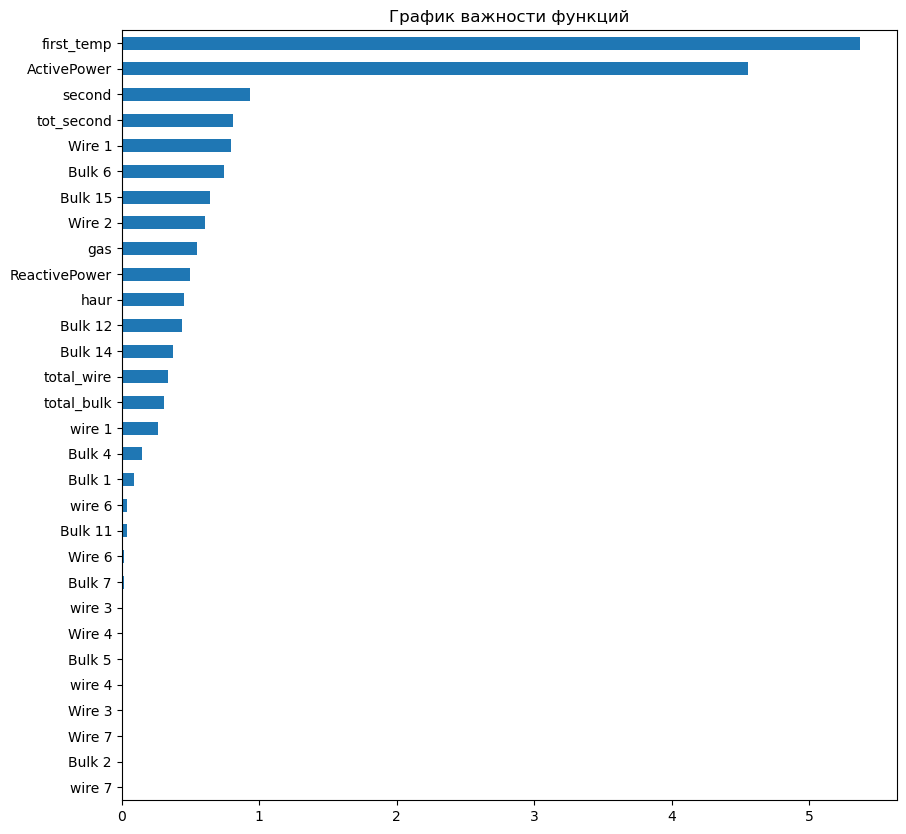

In [289]:
model_fi = permutation_importance(gsearch_forest, features_train, target_train)
pd.Series(model_fi['importances_mean'], index=features.columns).sort_values().plot(kind="barh") 
plt.title('График важности функций')
plt.show()

Найдем лучшую модель градиентного спуска прогноза последней измеренной температуры на метрике MAE. 

In [315]:
def c_mse_cv(params, random_state=RANDOM_STATE, cv=5, X=features_train, y=target_train):
    params = {'iterations': int(params['iterations']), 
              'depth': int(params['depth']), 
             'learning_rate': params['learning_rate'],
             'l2_leaf_reg': params['l2_leaf_reg']}

    model = CatBoostRegressor(random_seed=RANDOM_STATE, **params)
    
    
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    print(score)

    return score

In [ ]:
search_space = {'learning_rate': hp.uniform('learning_rate', 0.03, 0.1),
                'iterations': hp.randint('iterations',19, 380),
                'l2_leaf_reg': hp.randint('l2_leaf_reg', 3),
                'depth': hp.randint('depth', 1, 17)}
        
trials = Trials()
best=fmin(fn=c_mse_cv,
          space=search_space, 
          algo=tpe.suggest,
          max_evals = 3,                        
          trials=trials)

print("Best MSE {:.3f} params {}".format( c_mse_cv(best), best))

7.246003642131347                                                                                                      
 33%|█████████████████                                  | 1/3 [00:13<00:27, 13.81s/trial, best loss: 7.246003642131347]

In [138]:
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False) 
hyperparams = [{'learning_rate':[0.1, 0.2, 0.3],
                 'iterations': [100,300,500]}]
gsearch_cp = GridSearchCV(estimator=model_catboost, 
                       cv=5, 
                       param_grid=hyperparams,  
                       scoring='neg_mean_absolute_error')
gsearch_cp.fit(features_train, target_train) 
MAE_CBR_ordinal = gsearch_cp.best_score_ * -1
print(f' качество модели  равно {MAE_CBR_ordinal}')

 качество модели  равно 5.449421677090099


Параметры лучшей модели catboost:

In [139]:
gsearch_cp.best_params_

{'iterations': 300, 'learning_rate': 0.1}

Посмотрим на ранг важности функций для модели градиентного спуска.

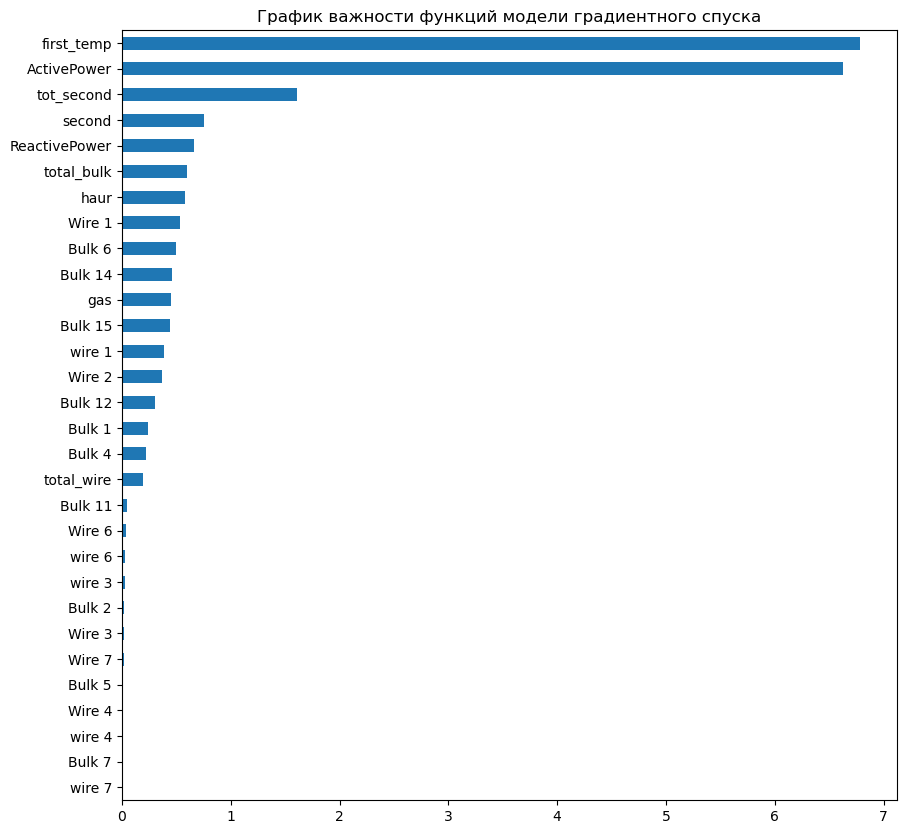

In [140]:
model_fi = permutation_importance(gsearch_cp, features_train, target_train)
pd.Series(model_fi['importances_mean'], index=features.columns).sort_values().plot(kind="barh")  
plt.title('График важности функций модели градиентного спуска')
plt.show()

In [ ]:
def gb_mse_cv(params, random_state=RANDOM_STATE, cv=5, X=x_train, y=y_train):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    model = LGBMRegressor(random_state=RANDOM_STATE, **params)
    
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    return score

In [ ]:
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)}
trials = Trials()
best=fmin(fn=gb_mse_cv,
          space=space, 
          algo=tpe.suggest,
          max_evals=15.0, 
          trials=trials) 
print("Best MSE {:.3f} params {}".format(gb_mse_cv(best), best))

##### Построение базовой нейронной сети

Проверим качество модели нейросеть на кросс-валидации.

In [141]:
sample_size = int(len(features)/5)
V_MAE = 2000
model_valid = None

for i in range(0, len(features), sample_size):
    print(i)
    valid_indexes = features.iloc[i: i + sample_size].index# < запишите массив из индексов для валидационного блока >
    train_indexes = (features.iloc[:i] + features.iloc[i+sample_size:]).index
    
    features_tr = features.loc[train_indexes]
    target_tr = target.loc[train_indexes]
    features_val = features.loc[valid_indexes]
    target_val = target.loc[valid_indexes]
    
    
    features_tr = col_transformer.transform(features_tr)
    features_val = col_transformer.transform(features_val)
    
    
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units=76, input_dim=features.shape[1], 
                             activation='sigmoid'))
    model.add(keras.layers.Dense(units=114,  activation='tanh'))
    model.add(keras.layers.Dense(units=19,  activation='relu'))
    model.add(keras.layers.Dense(units=1))#,  activation='relu'))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0)
    model.fit(features_tr, target_tr, epochs=200, verbose=2, batch_size=81, \
              validation_data=(features_val, target_val), callbacks=[callback])
    
    pr_temp = model.predict(features_val)
    MAE = mean_absolute_error(target_val, pr_temp)

    if V_MAE > MAE:
        model_valid = model
        V_MAE = MAE
print(f'Лучшая модель нейросети на кросс-валидации model_valid:  {model_valid}')
print(f'Качество модели нейронной сети на кросс-валидации: {V_MAE}')

0


Epoch 1/200

18/18 - 4s - loss: 1591.7329 - val_loss: 1589.6863 - 4s/epoch - 223ms/step
Epoch 2/200
18/18 - 0s - loss: 1586.6479 - val_loss: 1583.3689 - 214ms/epoch - 12ms/step
Epoch 3/200
18/18 - 0s - loss: 1579.7267 - val_loss: 1575.7744 - 192ms/epoch - 11ms/step
Epoch 4/200
18/18 - 0s - loss: 1571.5322 - val_loss: 1566.7942 - 206ms/epoch - 11ms/step
Epoch 5/200
18/18 - 0s - loss: 1561.8802 - val_loss: 1556.3352 - 202ms/epoch - 11ms/step
Epoch 6/200
18/18 - 0s - loss: 1550.7815 - val_loss: 1544.4382 - 213ms/epoch - 12ms/step
Epoch 7/200
18/18 - 0s - loss: 1538.2156 - val_loss: 1531.0310 - 229ms/epoch - 13ms/step
Epoch 8/200
18/18 - 0s - loss: 1524.1119 - val_loss: 1516.0569 - 218ms/epoch - 12ms/step
Epoch 9/200
18/18 - 0s - loss: 1508.4269 - val_loss: 1499.4843 - 230ms/epoch - 13ms/step
Epoch 10/200
18/18 - 0s - loss: 1491.1270 - val_loss: 1481.2832 - 192ms/epoch - 11ms/step
Epoch 11/200
18/18 - 0s - loss: 1472.1891 - val_loss: 1461.4351 - 205ms/epoch - 11ms/step
Epoch 12/200
18/

Epoch 89/200
18/18 - 0s - loss: 5.1651 - val_loss: 5.4539 - 208ms/epoch - 12ms/step
Epoch 90/200
18/18 - 0s - loss: 5.1265 - val_loss: 5.3165 - 201ms/epoch - 11ms/step
Epoch 91/200
18/18 - 0s - loss: 5.3444 - val_loss: 5.6755 - 206ms/epoch - 11ms/step
Epoch 92/200
18/18 - 0s - loss: 5.1195 - val_loss: 5.3932 - 202ms/epoch - 11ms/step
Epoch 93/200
18/18 - 0s - loss: 5.0672 - val_loss: 5.3203 - 194ms/epoch - 11ms/step
Epoch 94/200
18/18 - 0s - loss: 5.1065 - val_loss: 5.4440 - 204ms/epoch - 11ms/step
Epoch 95/200
18/18 - 0s - loss: 5.1458 - val_loss: 5.3852 - 202ms/epoch - 11ms/step
Epoch 96/200
18/18 - 0s - loss: 5.0242 - val_loss: 5.5210 - 199ms/epoch - 11ms/step
Epoch 97/200
18/18 - 0s - loss: 5.1152 - val_loss: 5.2856 - 203ms/epoch - 11ms/step
Epoch 98/200
18/18 - 0s - loss: 5.2574 - val_loss: 5.2349 - 207ms/epoch - 11ms/step
Epoch 99/200
18/18 - 0s - loss: 5.0673 - val_loss: 5.1899 - 202ms/epoch - 11ms/step
Epoch 100/200
18/18 - 0s - loss: 5.0642 - val_loss: 5.3159 - 205ms/epoch - 1

Epoch 55/200
18/18 - 0s - loss: 8.1785 - val_loss: 7.5921 - 218ms/epoch - 12ms/step
Epoch 56/200
18/18 - 0s - loss: 8.1426 - val_loss: 7.4958 - 209ms/epoch - 12ms/step
Epoch 57/200
18/18 - 0s - loss: 8.1372 - val_loss: 7.5085 - 208ms/epoch - 12ms/step
Epoch 58/200
18/18 - 0s - loss: 8.1472 - val_loss: 7.5146 - 212ms/epoch - 12ms/step
Epoch 59/200
18/18 - 0s - loss: 8.1295 - val_loss: 7.4828 - 200ms/epoch - 11ms/step
Epoch 60/200
18/18 - 0s - loss: 8.1247 - val_loss: 7.5094 - 208ms/epoch - 12ms/step
Epoch 61/200
18/18 - 0s - loss: 8.1274 - val_loss: 7.5580 - 206ms/epoch - 11ms/step
Epoch 62/200
18/18 - 0s - loss: 8.0914 - val_loss: 7.4597 - 204ms/epoch - 11ms/step
Epoch 63/200
18/18 - 0s - loss: 8.3371 - val_loss: 7.3975 - 204ms/epoch - 11ms/step
Epoch 64/200
18/18 - 0s - loss: 7.9194 - val_loss: 7.2999 - 202ms/epoch - 11ms/step
Epoch 65/200
18/18 - 0s - loss: 7.7520 - val_loss: 7.1678 - 212ms/epoch - 12ms/step
Epoch 66/200
18/18 - 0s - loss: 7.6224 - val_loss: 7.1550 - 217ms/epoch - 12

18/18 - 0s - loss: 1538.7395 - val_loss: 1529.8317 - 229ms/epoch - 13ms/step
Epoch 7/200
18/18 - 0s - loss: 1523.4944 - val_loss: 1513.8013 - 360ms/epoch - 20ms/step
Epoch 8/200
18/18 - 0s - loss: 1506.8086 - val_loss: 1496.2877 - 208ms/epoch - 12ms/step
Epoch 9/200
18/18 - 0s - loss: 1488.6154 - val_loss: 1477.2404 - 226ms/epoch - 13ms/step
Epoch 10/200
18/18 - 0s - loss: 1468.8722 - val_loss: 1456.6256 - 208ms/epoch - 12ms/step
Epoch 11/200
18/18 - 0s - loss: 1447.5514 - val_loss: 1434.4215 - 216ms/epoch - 12ms/step
Epoch 12/200
18/18 - 0s - loss: 1424.6338 - val_loss: 1410.6130 - 223ms/epoch - 12ms/step
Epoch 13/200
18/18 - 0s - loss: 1400.1058 - val_loss: 1385.1886 - 212ms/epoch - 12ms/step
Epoch 14/200
18/18 - 0s - loss: 1373.9587 - val_loss: 1358.1400 - 213ms/epoch - 12ms/step
Epoch 15/200
18/18 - 0s - loss: 1346.1852 - val_loss: 1329.4630 - 204ms/epoch - 11ms/step
Epoch 16/200
18/18 - 0s - loss: 1316.7815 - val_loss: 1299.1545 - 248ms/epoch - 14ms/step
Epoch 17/200
18/18 - 0s - 

Epoch 102/200
18/18 - 0s - loss: 5.0178 - val_loss: 5.7093 - 209ms/epoch - 12ms/step
Epoch 103/200
18/18 - 0s - loss: 5.0039 - val_loss: 5.7198 - 216ms/epoch - 12ms/step
Epoch 104/200
18/18 - 0s - loss: 5.0190 - val_loss: 5.6193 - 211ms/epoch - 12ms/step
Epoch 105/200
18/18 - 0s - loss: 5.0311 - val_loss: 5.5825 - 215ms/epoch - 12ms/step
Epoch 106/200
18/18 - 0s - loss: 5.1670 - val_loss: 5.5978 - 198ms/epoch - 11ms/step
Epoch 107/200
18/18 - 0s - loss: 5.1067 - val_loss: 5.5882 - 209ms/epoch - 12ms/step
Epoch 108/200
18/18 - 0s - loss: 5.1091 - val_loss: 5.4823 - 203ms/epoch - 11ms/step
Epoch 109/200
18/18 - 0s - loss: 4.9680 - val_loss: 5.5476 - 197ms/epoch - 11ms/step
Epoch 110/200
18/18 - 0s - loss: 4.9429 - val_loss: 5.5205 - 206ms/epoch - 11ms/step
Epoch 111/200
18/18 - 0s - loss: 4.9294 - val_loss: 5.5992 - 198ms/epoch - 11ms/step
Epoch 112/200
18/18 - 0s - loss: 5.0085 - val_loss: 5.5153 - 206ms/epoch - 11ms/step
Epoch 113/200
18/18 - 0s - loss: 4.9535 - val_loss: 5.5565 - 215m

18/18 - 0s - loss: 5.6988 - val_loss: 6.0256 - 227ms/epoch - 13ms/step
Epoch 74/200
18/18 - 0s - loss: 5.6807 - val_loss: 5.7859 - 221ms/epoch - 12ms/step
Epoch 75/200
18/18 - 0s - loss: 5.6089 - val_loss: 5.8684 - 229ms/epoch - 13ms/step
Epoch 76/200
18/18 - 0s - loss: 5.5759 - val_loss: 5.7678 - 226ms/epoch - 13ms/step
Epoch 77/200
18/18 - 0s - loss: 5.5176 - val_loss: 5.7573 - 234ms/epoch - 13ms/step
Epoch 78/200
18/18 - 0s - loss: 5.8162 - val_loss: 5.7480 - 250ms/epoch - 14ms/step
Epoch 79/200
18/18 - 0s - loss: 5.4442 - val_loss: 5.6291 - 261ms/epoch - 15ms/step
Epoch 80/200
18/18 - 0s - loss: 5.3843 - val_loss: 5.7386 - 248ms/epoch - 14ms/step
Epoch 81/200
18/18 - 0s - loss: 5.5655 - val_loss: 5.5677 - 299ms/epoch - 17ms/step
Epoch 82/200
18/18 - 0s - loss: 5.5926 - val_loss: 5.6442 - 265ms/epoch - 15ms/step
Epoch 83/200
18/18 - 0s - loss: 5.5719 - val_loss: 5.6140 - 241ms/epoch - 13ms/step
Epoch 84/200
18/18 - 0s - loss: 5.6439 - val_loss: 5.7314 - 238ms/epoch - 13ms/step
Epoch

Epoch 40/200
18/18 - 0s - loss: 8.4029 - val_loss: 8.0052 - 199ms/epoch - 11ms/step
Epoch 41/200
18/18 - 0s - loss: 8.1292 - val_loss: 7.8068 - 192ms/epoch - 11ms/step
Epoch 42/200
18/18 - 0s - loss: 8.0560 - val_loss: 7.8684 - 194ms/epoch - 11ms/step
Epoch 43/200
18/18 - 0s - loss: 8.1283 - val_loss: 7.8095 - 201ms/epoch - 11ms/step
Epoch 44/200
18/18 - 0s - loss: 8.0550 - val_loss: 7.8069 - 202ms/epoch - 11ms/step
Epoch 45/200
18/18 - 0s - loss: 8.0658 - val_loss: 7.8206 - 200ms/epoch - 11ms/step
Epoch 46/200
18/18 - 0s - loss: 8.1269 - val_loss: 7.8784 - 188ms/epoch - 10ms/step
Epoch 47/200
18/18 - 0s - loss: 8.0233 - val_loss: 7.8207 - 189ms/epoch - 10ms/step
Epoch 48/200
18/18 - 0s - loss: 8.1960 - val_loss: 7.8383 - 200ms/epoch - 11ms/step
Epoch 49/200
18/18 - 0s - loss: 7.9566 - val_loss: 7.7708 - 188ms/epoch - 10ms/step
Epoch 50/200
18/18 - 0s - loss: 7.7749 - val_loss: 7.5657 - 197ms/epoch - 11ms/step
Epoch 51/200
18/18 - 0s - loss: 7.6335 - val_loss: 7.7660 - 199ms/epoch - 11

In [142]:
print(f'Лучшая модель нейросети на кросс-валидации model_valid:  {model_valid}')
print(f'Качество модели нейронной сети на кросс-валидации: {V_MAE}')

Лучшая модель нейросети на кросс-валидации model_valid:  <keras.src.engine.sequential.Sequential object at 0x000001E5AE662110>
Качество модели нейронной сети на кросс-валидации: 5.226804871490036


##### Вывод:
         В ходе экспериментов с моделями были натренированны черыре модели - случяйный лес, catboost, константные и с
    помощью автоматического подбора параметров(GridSearchCV), а так  же полносвязная нейронная  сеть.  По результатам
    все модели вкладываються в рамки технического задания.
   1) Cлучайный лес, качество модели по кросс-валидации  MAE = 5.92
      Гиперпараметры max_depth: 13, min_samples_leaf : 4, min_samples_split: 2, n_estimators: 25
   2) Catboost качество модели по кросс-валидации  MAE = 5.51
      Гиперпараметры iterations: 300, learning_rate: 0.1, random_state: 1515
   3) Cлучайный лес, константная модель на валидционной выборке MAE = 6.14
   4) Catboost качество модели на валидционной выборке MAE = 5.8
   5) Нейронная сеть MAE = 5.7

##### Тестирование лучшей модели на тестовой выборке.

По результатам кросс-валидации  лучшей моделью окозалась модель нейронная сеть, протестирует ее на 
тестовой выборке. 

In [143]:
pr_temp = model_valid.predict(features_test)
MAE = mean_absolute_error(target_test, pr_temp)
RMSE = mean_squared_error(target_test, pr_temp)**0.5
print(f'Качество  модели нейронной сети на тестовой выборке MAE = {MAE}')
print(f'Качество  модели нейронной сети на тестовой выборке RMSE = {RMSE}')

18/18 [==============================] - 0s 5ms/step
Качество  модели нейронной сети на тестовой выборке MAE = 5.404627058241102
Качество  модели нейронной сети на тестовой выборке RMSE = 7.331992937016534


Сравним  результат лучшей  и константной модели.

In [144]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
pred_const = dummy_regr.predict(features_test)
print(f' Качество константной модели на валидационной выборке : {mean_absolute_error(target_test, pred_const)}')
print(f'Качество  константной модели на тестовой выборке RMSE = {mean_squared_error(target_test, pred_const)**0.5}')


 Качество константной модели на валидационной выборке : 8.337708333333332
Качество  константной модели на тестовой выборке RMSE = 11.626659857605038


In [146]:
model_c = CatBoostRegressor(learning_rate = 0.1772564374468707, iterations = 672, depth = 4,\
                            l2_leaf_reg = 7, early_stopping_rounds = 100,\
                            bootstrap_type = 'Bernoulli', random_state = RANDOM_STATE)

In [147]:
target_train

key
1147    1597.0
1476    1611.0
861     1619.0
826     1598.0
34      1600.0
         ...  
1185    1573.0
846     1591.0
716     1617.0
1270    1617.0
1994    1587.0
Name: last_temp, Length: 1725, dtype: float64

In [148]:
model_c.fit(X = features_train, y = target_train, eval_set=(features_test,target_test),verbose=250)

0:	learn: 10.6677234	test: 11.2575848	best: 11.2575848 (0)	total: 149ms	remaining: 1m 40s
250:	learn: 4.9289794	test: 7.6046225	best: 7.5968476 (231)	total: 1.86s	remaining: 3.12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 7.596847642
bestIteration = 231

Shrink model to first 232 iterations.


In [152]:
#features_test

In [149]:
#p_mp = model_c.predict(features_test)

In [150]:
#MAE = mean_absolute_error(target_test, p_mp)
#RMSE = mean_squared_error(target_test, p_mp)**0.5

In [151]:
#MAE, RMSE

###### Вывод:
Качество модели  нейронная сеть выше чем константной.

Анализ важности признаков модели.

In [145]:
f_n = shap.sample(features_tr, 100)
f_t = shap.sample(features_val, 100)
explainer = shap.KernelExplainer(model_valid.predict, f_n)
shap_values = explainer.shap_values(f_t, nsamples=30)

4/4 [==============================] - 0s 6ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.396e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 23 iterations, alpha=6.173e-02, previous alpha=5.340e-02, with an active set of 18 regressors.
Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.533e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.301e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 26 iterations, alpha=1.072e-01, previous alpha=1.072e-01, with an active set of 17 regressors.
Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features toge

94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.009e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.448e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=7.036e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=3.627e-03, previous alpha=3.414e-03, with an active set of 15 regressors.


94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=9.680e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.324e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=8.070e-03, previous alpha=4.607e-03, with an active set of 15 regressors.


94/94 [==============================] - 0s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.839e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.511e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=4.777e-02, previous alpha=2.208e-02, with an active set of 15 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.031e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.613e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.882e-02, with an active set of 16 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=1.882e-02, previous alpha=1.630e-02, with an active set of 16 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.722e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.511e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.784e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.141e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues 

94/94 [==============================] - 0s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.094e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.987e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.691e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=2.959e-02, previous alpha=2.402e-02, with an active set of 13 regressors.


94/94 [==============================] - 1s 5ms/step


Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=1.379e-03, previous alpha=1.379e-03, with an active set of 17 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.086e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.509e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=1.509e-03, previous alpha=1.281e-03, with an active set of 16 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.119e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 33 iterations, alpha=3.031e-03, previous alpha=3.031e-03, with an active set of 14 regressors.


94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.639e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.150e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.045e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=9.579e-02, previous alpha=8.959e-02, with an active set of 10 regressors.


94/94 [==============================] - 0s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.912e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.766e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=2.230e-01, previous alpha=2.960e-02, with an active set of 23 regressors.


94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.131e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.310e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=1.014e-01, previous alpha=9.092e-02, with an active set of 10 regressors.


94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.034e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=1.810e-01, previous alpha=1.676e-01, with an active set of 11 regressors.
Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.


94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.147e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=3.033e-02, previous alpha=1.954e-02, with an active set of 16 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.976e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.515e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.487e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=3.153e-02, previous alpha=2.451e-02, with an active set of 10 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=3.384e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=7.974e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=7.974e-04, previous alpha=6.490e-04, with an active set of 16 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.931e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.965e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.630e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=1.630e-01, previous alpha=1.620e-01, with an active set of 9 regressors.


94/94 [==============================] - 0s 4ms/step


Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.


94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.504e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.485e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=3.692e-03, previous alpha=2.985e-03, with an active set of 16 regressors.


94/94 [==============================] - 0s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.449e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.007e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.007e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.920e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.038e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.218e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.275e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.926e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.201e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=5.227e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.519e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=3.845e-02, previous alpha=3.067e-02, with an active set of 12 regressors.
Linear regression equation is singular, a least squares solutions is use

94/94 [==============================] - 1s 5ms/step


Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=3.806e-02, previous alpha=3.726e-02, with an active set of 11 regressors.


94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.297e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=6.486e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=6.486e-03, previous alpha=6.428e-03, with an active set of 14 regressors.


94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.614e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=1.255e-02, previous alpha=1.255e-02, with an active set of 17 regressors.


94/94 [==============================] - 1s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.980e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.791e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=1.375e-02, previous alpha=1.212e-02, with an active set of 16 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.066e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=8.520e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=8.509e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=4.761e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residue

94/94 [==============================] - 1s 6ms/step


Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.745e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.825e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=1.009e-01, previous alpha=6.818e-02, with an active set of 17 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=3.726e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=1.901e-02, previous alpha=1.901e-02, with an active set of 15 regressors.


94/94 [==============================] - 0s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.612e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.942e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=9.355e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=9.024e-02, previous alpha=8.723e-02, with an active set of 12 regressors.
Linear regression equation is singular, a least squares solutions is use

94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.318e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.507e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=3.507e-01, previous alpha=3.504e-01, with an active set of 6 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.987e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=1.987e-03, previous alpha=1.923e-03, with an active set of 14 regressors.
Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.


94/94 [==============================] - 0s 5ms/step


Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.895e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.473e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.472e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=9.473e-01, previous alpha=9.472e-01, with an active set of 6 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.745e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.901e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.850e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.751e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping 

94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.676e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.676e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=4.676e-02, previous alpha=4.665e-02, with an active set of 11 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.520e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.825e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=1.487e-01, previous alpha=1.427e-01, with an active set of 11 regressors.


94/94 [==============================] - 0s 4ms/step


Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.993e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.383e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.482e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.311e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues ar

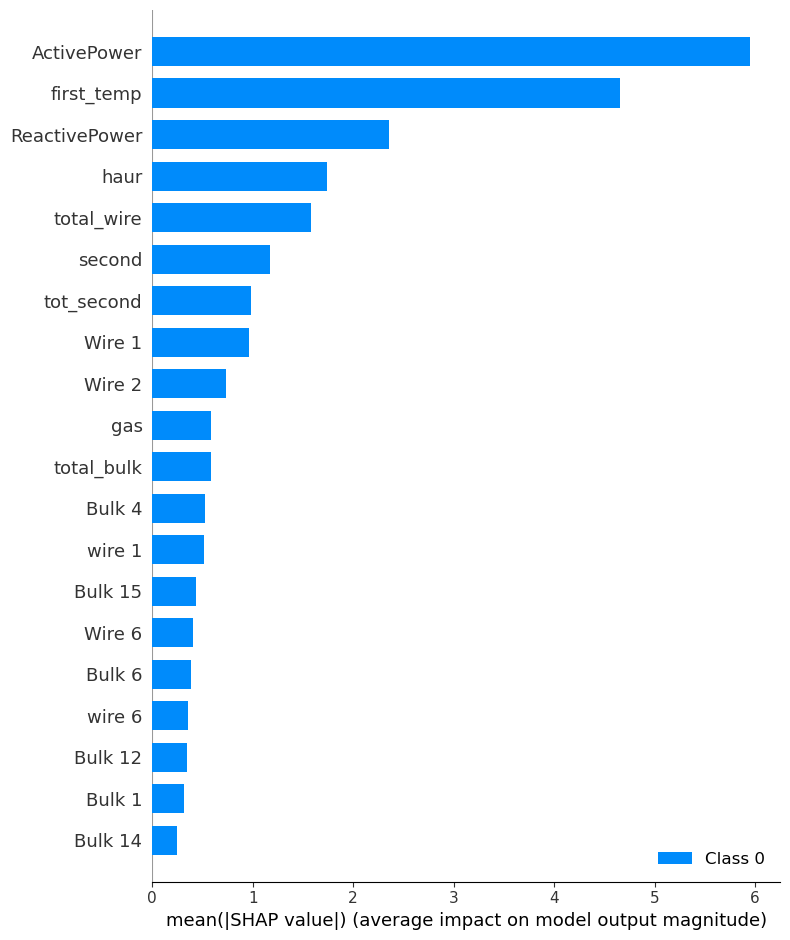

In [146]:
shap.summary_plot(shap_values, feature_names=features.columns)

График важности функций модели нейронная сеть

In [147]:
explainer

In [148]:
len(shap_values)

1

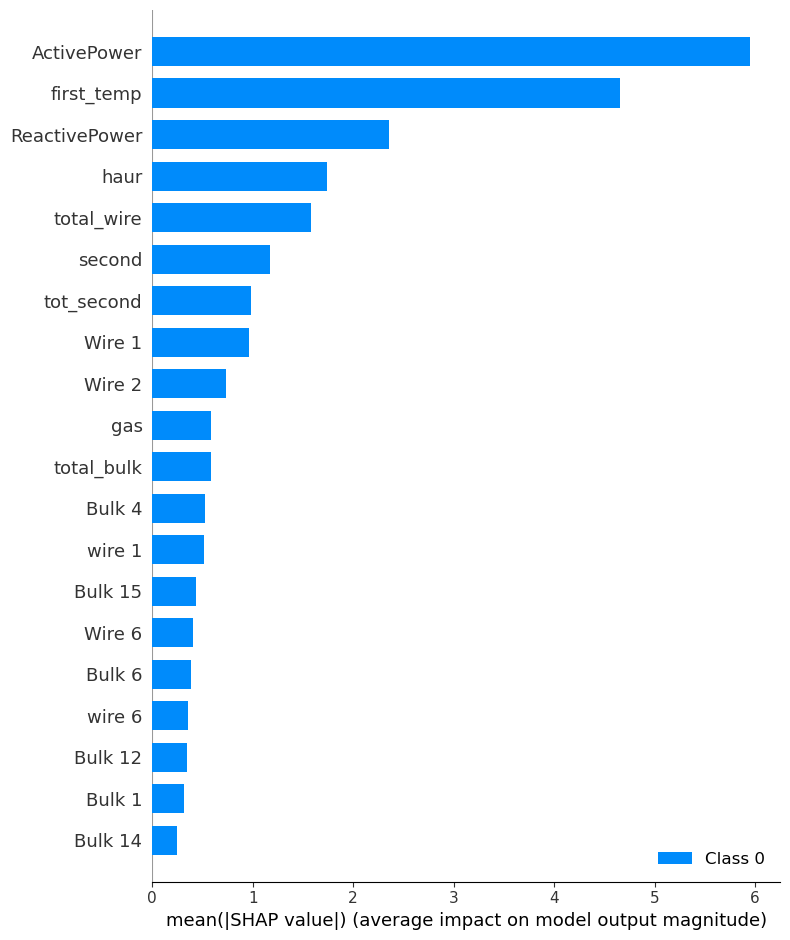

In [149]:
shap.summary_plot(shap_values, f_t, feature_names=features.columns)

Изначально полагалось, что наиболее важным признаком для моделей будет тот признак,
корреляция которого с целевым выше(это признак начальная температура металла),  да 
и такой аргумент как вес металла в ковше, ведь 100 тон металла обладают значительной 
теплоемкостью. В результате исследования поучили ранг значимости признаков. На первом
месте признак значение активной мощности, на втором -начальная температура металла,
на третьем месте - время обработки партии.

##### Вывод:
По результатам исследования установленно - самый важный признак для модели является "значение
активной мощности".

In [150]:
graf = data[['last_temp', 'ActivePower']]

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


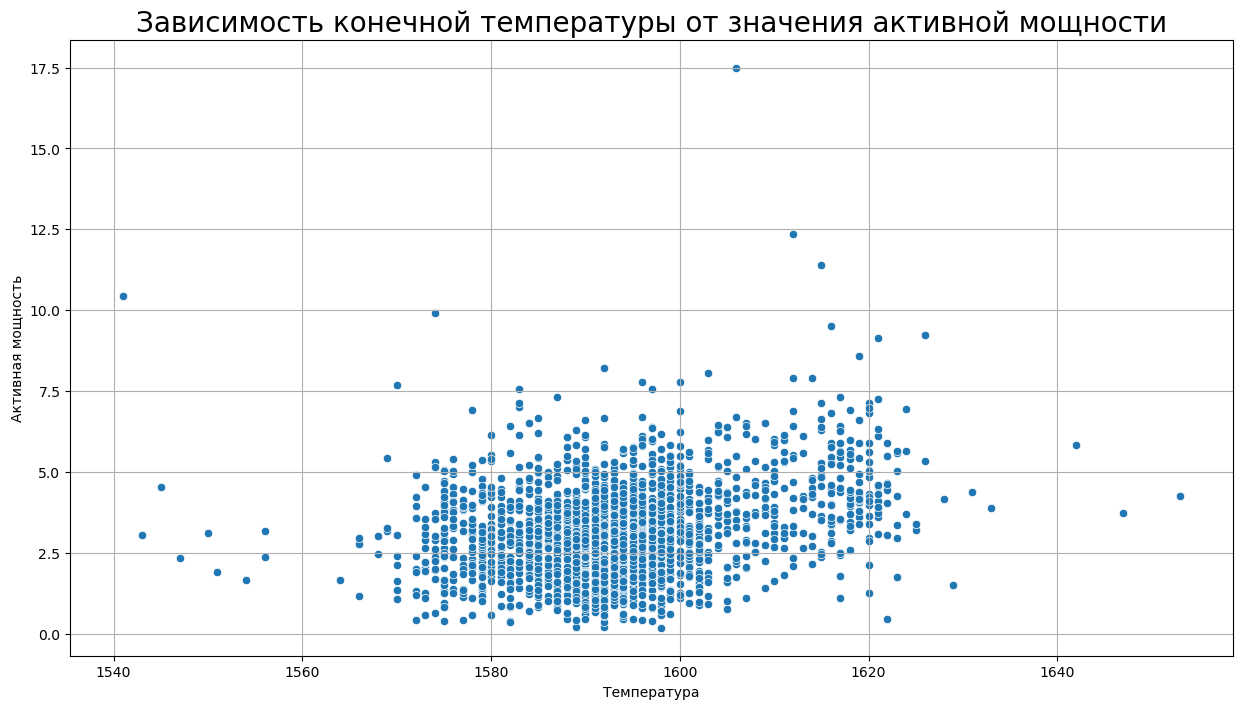


             last_temp  ActivePower
last_temp     1.000000     0.284814
ActivePower   0.284814     1.000000


In [151]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=graf, x="last_temp", y="ActivePower")
plt.title('Зависимость конечной температуры от значения активной мощности', fontsize=20)
plt.xlabel('Температура')
plt.ylabel('Активная мощность')
plt.grid(True)
plt.show()

print()

print(graf.corr())

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='last_temp', ylabel='ActivePower'>

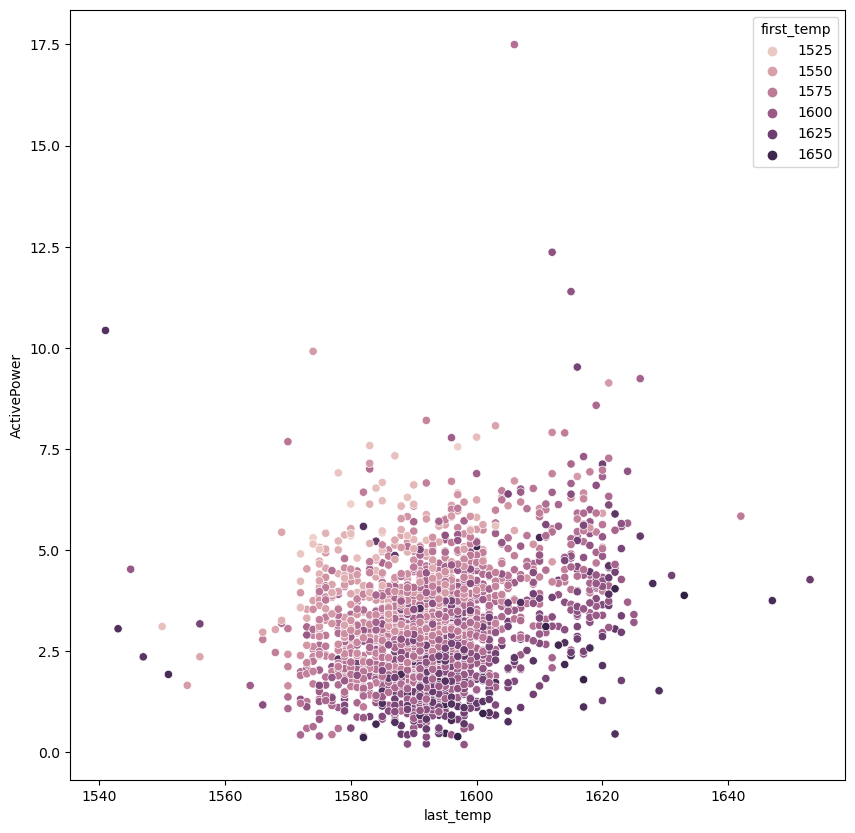

In [152]:
sns.scatterplot(x=data["last_temp"], y=data["ActivePower"], hue = data['first_temp'])

На графике видно слабую корреляцию с объём подаваемых проволочных материалов в ковш и конечным.
На конечную температуру еще влияют множество факторов.

#### Вывод:

    Заказчик этого исследования -  металлургический комбинат «Стальная птица» 
    Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил
    уменьшить потребление    электроэнергии на этапе обработки стали. Для этого комбинату нужно
    контролировать температуру сплава.  Была произведена обработка и  исследовательски анализ данных.
    На основании подготовленных данных били построенны модели для прогноза последней температуры в котле.
    
    Рекомендации:
       - Для более точного сбора информации необходимо избавиться от асинхронности датчиков.
       - Добавить в таблицы температуры бобавляемых веществ.
       - Добавить в таблицу номенклатуру сырья, если оно разное, так как в ходе исследования 
         сложилось впечатление, что партии имеют небольшую разницу в теплоемкости.
    
        На температуру в котле влияют множество факторов, такие факторы как время подачи материалов, по 
    всей видимости температура материалов (не был указан в таблицах), какждый фактор в отдельности 
    малозначим, но в сумме они влияют на  конечную темрературу.